# NOTEBOOK FOR THE ANALYSIS OF SINGLE-NUCLEI RNA-SEQUENCING DATA FROM LFS MEDULLOBLASTOMA

In [1]:
# import the modules needed for the analysis
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import scrublet as scr
from matplotlib import rcParams
import matplotlib
from SCCAF import SCCAF_assessment, plot_roc, SCCAF_optimize_all
import session_info
import mnnpy
import scanpy.external as sce
import harmonypy

/home/przybilm/.local/lib/python3.7/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x2b2282f8dbf8>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2351.
    With argument(s): '(x=array(float32, 2d, A), axis=int64)':
   Rejected as the implementation raised a specific error:
     TypeError: norm_impl() got an unexpected keyword argument 'x'
  raised from /home/przybilm/.local/lib/python3.7/site-packages/numba/core/typing/templates.py:775

During: resolving callee type: Function(<function norm at 0x2b2282f8dbf8>)
During: typing of call at /home/przybilm/.local/lib/python3.7/site-packages/mnnpy/utils.py (16)


File "../../.local/lib/p

In [2]:
session_info.show()

In [3]:
# set parameters
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white',  dpi_save=600)

In [4]:
results_file = '/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/adata_nuclei.h5ad'  # the file that will store the analysis results


## READ IN THE DATA FOR LFSMBP-NUCLEI AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [5]:
adata_lfsmbp = sc.read_10x_mtx(
    '/omics/groups/OE0540/internal/projects/chromothripsis_medulloblastoma/data/10XRNA5P/LFSMBP/LFSMBP-Nuclei/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata_lfsmbp.var_names_make_unique()
adata_lfsmbp

# make some metadata
adata_lfsmbp.obs['sample'] = "LFSMBP"
adata_lfsmbp.obs['technology'] = "Nuclei"
adata_lfsmbp.obs['patient'] = "ST"

... reading from cache file cache/omics-groups-OE0540-internal-projects-chromothripsis_medulloblastoma-data-10XRNA5P-STP-STP-Nuclei-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [6]:
scrub_lfsmbp = scr.Scrublet(
        counts_matrix=adata_lfsmbp.X,
        expected_doublet_rate=0.1,  # Default is 0.1
        random_state=0)

In [7]:
doublet_scores, predicted_doublets = scrub_lfsmbp.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.0%
Elapsed time: 9.1 seconds


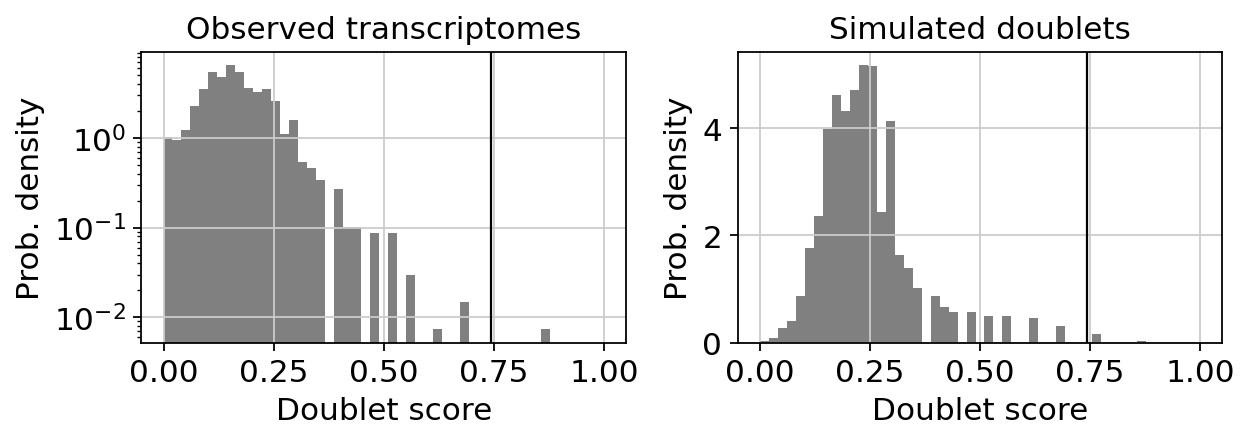

In [8]:
scrub_lfsmbp.plot_histogram();

In [9]:
adata_lfsmbp.obs['scrublet__predicted_multiplet'] = scrub_lfsmbp.predicted_doublets_
adata_lfsmbp.obs['scrublet__multiplet_scores'] = scrub_lfsmbp.doublet_scores_obs_
adata_lfsmbp.obs['scrublet__multiplet_zscores'] = scrub_lfsmbp.z_scores_

In [10]:
adata_lfsmbp.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGCACATCCAA-1    STP     Nuclei      ST                          False   
AAACCTGCACTAGTAC-1    STP     Nuclei      ST                          False   
AAACCTGCATCATCCC-1    STP     Nuclei      ST                          False   
AAACCTGGTAGCGATG-1    STP     Nuclei      ST                          False   
AAACCTGGTAGCTCCG-1    STP     Nuclei      ST                          False   
...                   ...        ...     ...                            ...   
TTTGTCAGTGCGCTTG-1    STP     Nuclei      ST                          False   
TTTGTCAGTGTTTGTG-1    STP     Nuclei      ST                          False   
TTTGTCAGTTAAAGAC-1    STP     Nuclei      ST                          False   
TTTGTCATCATCGGAT-1    STP     Nuclei      ST                          False   
TTTGTCATCCCAAGAT-1    STP     Nuclei      ST                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGCACATCCAA-1                    0.215768                    -9.569958  
AAACCTGCACTAGTAC-1                    0.134111                   -17.467151  
AAACCTGCATCATCCC-1                    0.081828                   -30.576015  
AAACCTGGTAGCGATG-1                    0.248260                    -7.865708  
AAACCTGGTAGCTCCG-1                    0.155340                   -14.623827  
...                                        ...                          ...  
TTTGTCAGTGCGCTTG-1                    0.197674                   -10.761051  
TTTGTCAGTGTTTGTG-1                    0.248260                    -7.865708  
TTTGTCAGTTAAAGAC-1                    0.155340                   -14.623827  
TTTGTCATCATCGGAT-1                    0.134111                   -17.467151  
TTTGTCATCCCAAGAT-1                    0.225806                    -8.991166  

[6669 rows x 6 columns]

In [11]:
# count the number of predicted multiplets
adata_lfsmbp.obs['scrublet__predicted_multiplet'].value_counts() 

False    6668
True        1
Name: scrublet__predicted_multiplet, dtype: int64

In [12]:
# remove predicted doublets
adata_lfsmbp = adata_lfsmbp[adata_lfsmbp.obs['scrublet__predicted_multiplet'] == False]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [13]:
adata_lfsmbp.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGCACATCCAA-1    STP     Nuclei      ST                          False   
AAACCTGCACTAGTAC-1    STP     Nuclei      ST                          False   
AAACCTGCATCATCCC-1    STP     Nuclei      ST                          False   
AAACCTGGTAGCGATG-1    STP     Nuclei      ST                          False   
AAACCTGGTAGCTCCG-1    STP     Nuclei      ST                          False   
...                   ...        ...     ...                            ...   
TTTGTCAGTGCGCTTG-1    STP     Nuclei      ST                          False   
TTTGTCAGTGTTTGTG-1    STP     Nuclei      ST                          False   
TTTGTCAGTTAAAGAC-1    STP     Nuclei      ST                          False   
TTTGTCATCATCGGAT-1    STP     Nuclei      ST                          False   
TTTGTCATCCCAAGAT-1    STP     Nuclei      ST                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGCACATCCAA-1                    0.215768                    -9.569958  
AAACCTGCACTAGTAC-1                    0.134111                   -17.467151  
AAACCTGCATCATCCC-1                    0.081828                   -30.576015  
AAACCTGGTAGCGATG-1                    0.248260                    -7.865708  
AAACCTGGTAGCTCCG-1                    0.155340                   -14.623827  
...                                        ...                          ...  
TTTGTCAGTGCGCTTG-1                    0.197674                   -10.761051  
TTTGTCAGTGTTTGTG-1                    0.248260                    -7.865708  
TTTGTCAGTTAAAGAC-1                    0.155340                   -14.623827  
TTTGTCATCATCGGAT-1                    0.134111                   -17.467151  
TTTGTCATCCCAAGAT-1                    0.225806                    -8.991166  

[6668 rows x 6 columns]

## READ IN THE DATA FOR LFSMB1R-NUCLEI AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [14]:
adata_lfsmb1r = sc.read_10x_mtx(
    '/omics/groups/OE0540/internal/projects/chromothripsis_medulloblastoma/data/10XRNA5P/LFSMB1R/LFSMB1R-Nuclei/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata_lfsmb1r.var_names_make_unique()
adata_lfsmb1r

# make some metadata
adata_lfsmb1r.obs['sample'] = "lfsmb1r"
adata_lfsmb1r.obs['technology'] = "Nuclei"
adata_lfsmb1r.obs['patient'] = "ST"

... reading from cache file cache/omics-groups-OE0540-internal-projects-chromothripsis_medulloblastoma-data-10XRNA5P-ST1R-ST1R-Nuclei-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [15]:
scrub_lfsmb1r = scr.Scrublet(
        counts_matrix=adata_lfsmb1r.X,
        expected_doublet_rate=0.1,  # Default is 0.1
        random_state=0)

In [16]:
doublet_scores, predicted_doublets = scrub_lfsmb1r.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.9%
Elapsed time: 1.0 seconds


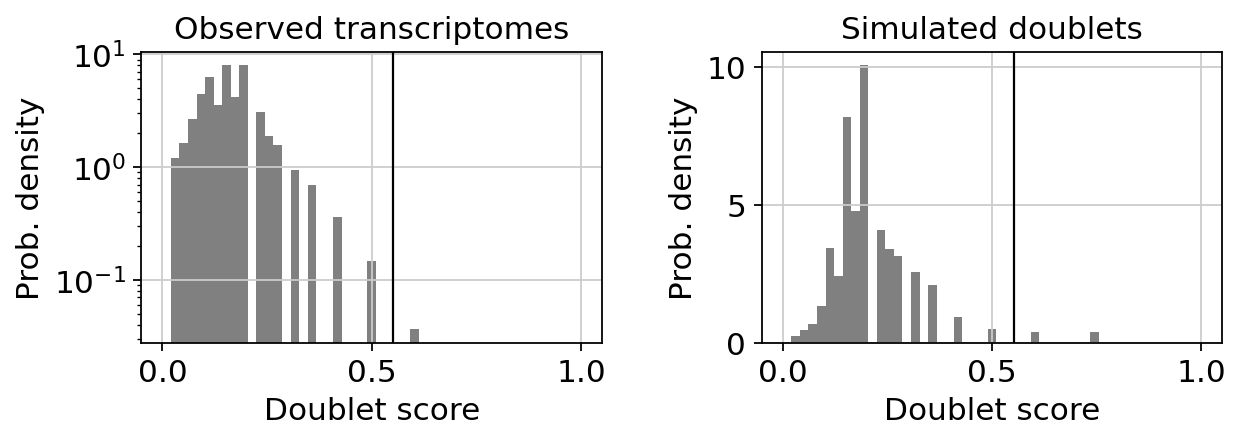

In [17]:
scrub_lfsmb1r.plot_histogram();

In [18]:
adata_lfsmb1r.obs['scrublet__predicted_multiplet'] = adata_lfsmb1r.predicted_doublets_
adata_lfsmb1r.obs['scrublet__multiplet_scores'] = adata_lfsmb1r.doublet_scores_obs_
adata_lfsmb1r.obs['scrublet__multiplet_zscores'] = adata_lfsmb1r.z_scores_

In [19]:
adata_lfsmb1r.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGAGCACCGCT-1   ST1R     Nuclei      ST                          False   
AAACCTGGTGATAAGT-1   ST1R     Nuclei      ST                          False   
AAACCTGGTGCGAAAC-1   ST1R     Nuclei      ST                          False   
AAACGGGTCGAGAGCA-1   ST1R     Nuclei      ST                          False   
AAACGGGTCGTCTGCT-1   ST1R     Nuclei      ST                          False   
...                   ...        ...     ...                            ...   
TTTGTCACATTCGACA-1   ST1R     Nuclei      ST                          False   
TTTGTCAGTCCGAGTC-1   ST1R     Nuclei      ST                          False   
TTTGTCAGTTTGTTGG-1   ST1R     Nuclei      ST                          False   
TTTGTCATCCGCAGTG-1   ST1R     Nuclei      ST                          False   
TTTGTCATCCGTAGTA-1   ST1R     Nuclei      ST                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGAGCACCGCT-1                    0.097625                   -14.416189  
AAACCTGGTGATAAGT-1                    0.185185                    -6.056803  
AAACCTGGTGCGAAAC-1                    0.155235                    -7.857097  
AAACGGGTCGAGAGCA-1                    0.142857                    -8.823592  
AAACGGGTCGTCTGCT-1                    0.052632                   -28.927253  
...                                        ...                          ...  
TTTGTCACATTCGACA-1                    0.280000                    -2.938771  
TTTGTCAGTCCGAGTC-1                    0.045936                   -33.302516  
TTTGTCAGTTTGTTGG-1                    0.121951                   -10.900300  
TTTGTCATCCGCAGTG-1                    0.131833                    -9.837172  
TTTGTCATCCGTAGTA-1                    0.025641                   -58.402356  

[1342 rows x 6 columns]

In [20]:
# count the number of predicted multiplets
adata_lfsmb1r.obs['scrublet__predicted_multiplet'].value_counts() 

False    1341
True        1
Name: scrublet__predicted_multiplet, dtype: int64

In [21]:
# remove predicted doublets
adata_lfsmb1r = adata_lfsmb1r[adata_lfsmb1r.obs['scrublet__predicted_multiplet'] == False]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [22]:
adata_lfsmb1r.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGAGCACCGCT-1   ST1R     Nuclei      ST                          False   
AAACCTGGTGATAAGT-1   ST1R     Nuclei      ST                          False   
AAACCTGGTGCGAAAC-1   ST1R     Nuclei      ST                          False   
AAACGGGTCGAGAGCA-1   ST1R     Nuclei      ST                          False   
AAACGGGTCGTCTGCT-1   ST1R     Nuclei      ST                          False   
...                   ...        ...     ...                            ...   
TTTGTCACATTCGACA-1   ST1R     Nuclei      ST                          False   
TTTGTCAGTCCGAGTC-1   ST1R     Nuclei      ST                          False   
TTTGTCAGTTTGTTGG-1   ST1R     Nuclei      ST                          False   
TTTGTCATCCGCAGTG-1   ST1R     Nuclei      ST                          False   
TTTGTCATCCGTAGTA-1   ST1R     Nuclei      ST                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGAGCACCGCT-1                    0.097625                   -14.416189  
AAACCTGGTGATAAGT-1                    0.185185                    -6.056803  
AAACCTGGTGCGAAAC-1                    0.155235                    -7.857097  
AAACGGGTCGAGAGCA-1                    0.142857                    -8.823592  
AAACGGGTCGTCTGCT-1                    0.052632                   -28.927253  
...                                        ...                          ...  
TTTGTCACATTCGACA-1                    0.280000                    -2.938771  
TTTGTCAGTCCGAGTC-1                    0.045936                   -33.302516  
TTTGTCAGTTTGTTGG-1                    0.121951                   -10.900300  
TTTGTCATCCGCAGTG-1                    0.131833                    -9.837172  
TTTGTCATCCGTAGTA-1                    0.025641                   -58.402356  

[1341 rows x 6 columns]

## READ IN THE DATA FOR MB243-NUCLEI AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [23]:
adata_mb243 = sc.read_10x_mtx(
    '/omics/groups/OE0540/internal/projects/chromothripsis_medulloblastoma/data/10XRNA5P/MB243/MB243-Nuclei/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata_mb243.var_names_make_unique()
adata_mb243

# make some metadata
adata_mb243.obs['sample'] = "MB243"
adata_mb243.obs['technology'] = "Nuclei"
adata_mb243.obs['patient'] = "MB243"

... reading from cache file cache/omics-groups-OE0540-internal-projects-chromothripsis_medulloblastoma-data-10XRNA5P-MB243-MB243-Nuclei-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [24]:
scrub_mb243 = scr.Scrublet(
        counts_matrix=adata_mb243.X,
        expected_doublet_rate=0.1,  # Default is 0.1
        random_state=0)

In [25]:
doublet_scores, predicted_doublets = scrub_mb243.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 15.9 seconds


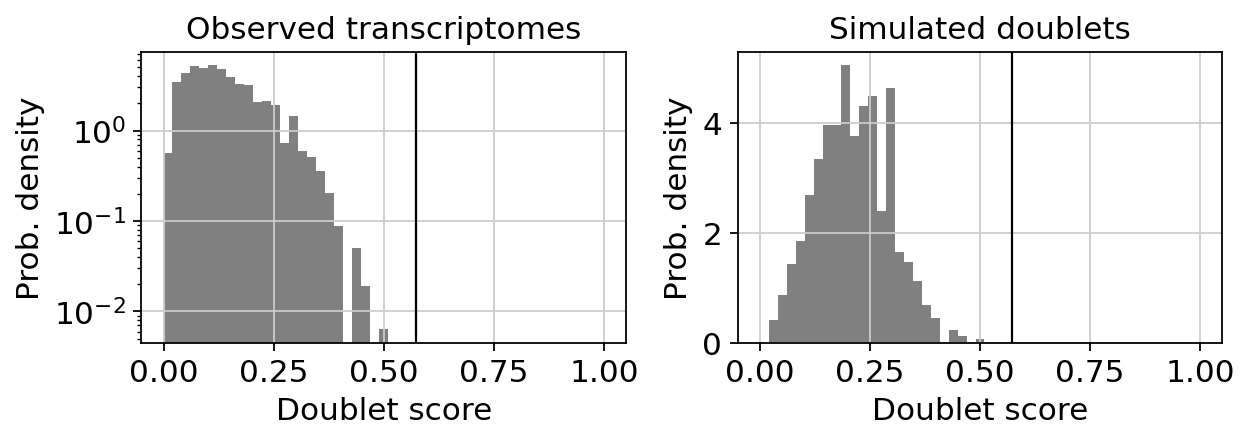

In [26]:
scrub_mb243.plot_histogram();

In [27]:
adata_mb243.obs['scrublet__predicted_multiplet'] = scrub_mb243.predicted_doublets_
adata_mb243.obs['scrublet__multiplet_scores'] = scrub_mb243.doublet_scores_obs_
adata_mb243.obs['scrublet__multiplet_zscores'] = scrub_mb243.z_scores_

In [28]:
adata_mb243.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGAGAAACCGC-1  MB243     Nuclei   MB243                          False   
AAACCTGAGAACAATC-1  MB243     Nuclei   MB243                          False   
AAACCTGAGCACCGTC-1  MB243     Nuclei   MB243                          False   
AAACCTGAGCAGCGTA-1  MB243     Nuclei   MB243                          False   
AAACCTGAGGAATTAC-1  MB243     Nuclei   MB243                          False   
...                   ...        ...     ...                            ...   
TTTGTCATCAATCACG-1  MB243     Nuclei   MB243                          False   
TTTGTCATCACCATAG-1  MB243     Nuclei   MB243                          False   
TTTGTCATCCCAACGG-1  MB243     Nuclei   MB243                          False   
TTTGTCATCGCTTGTC-1  MB243     Nuclei   MB243                          False   
TTTGTCATCTATGTGG-1  MB243     Nuclei   MB243                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGAGAAACCGC-1                    0.111913                   -16.007561  
AAACCTGAGAACAATC-1                    0.220472                    -6.393604  
AAACCTGAGCACCGTC-1                    0.140449                   -12.064751  
AAACCTGAGCAGCGTA-1                    0.071823                   -26.647222  
AAACCTGAGGAATTAC-1                    0.305913                    -3.583664  
...                                        ...                          ...  
TTTGTCATCAATCACG-1                    0.090526                   -20.546005  
TTTGTCATCACCATAG-1                    0.202952                    -7.257215  
TTTGTCATCCCAACGG-1                    0.220472                    -6.393604  
TTTGTCATCGCTTGTC-1                    0.173770                    -9.076989  
TTTGTCATCTATGTGG-1                    0.055690                   -35.040172  

[7724 rows x 6 columns]

In [29]:
adata_mb243.obs['scrublet__predicted_multiplet'].value_counts() 

False    7724
Name: scrublet__predicted_multiplet, dtype: int64

In [30]:
# remove predicted doublets
adata_mb243 = adata_mb243[adata_mb243.obs['scrublet__predicted_multiplet'] == False]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [31]:
adata_mb243.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGAGAAACCGC-1  MB243     Nuclei   MB243                          False   
AAACCTGAGAACAATC-1  MB243     Nuclei   MB243                          False   
AAACCTGAGCACCGTC-1  MB243     Nuclei   MB243                          False   
AAACCTGAGCAGCGTA-1  MB243     Nuclei   MB243                          False   
AAACCTGAGGAATTAC-1  MB243     Nuclei   MB243                          False   
...                   ...        ...     ...                            ...   
TTTGTCATCAATCACG-1  MB243     Nuclei   MB243                          False   
TTTGTCATCACCATAG-1  MB243     Nuclei   MB243                          False   
TTTGTCATCCCAACGG-1  MB243     Nuclei   MB243                          False   
TTTGTCATCGCTTGTC-1  MB243     Nuclei   MB243                          False   
TTTGTCATCTATGTGG-1  MB243     Nuclei   MB243                          False   

                    scrublet__multiplet_scores  scrublet__multiplet_zscores  
AAACCTGAGAAACCGC-1                    0.111913                   -16.007561  
AAACCTGAGAACAATC-1                    0.220472                    -6.393604  
AAACCTGAGCACCGTC-1                    0.140449                   -12.064751  
AAACCTGAGCAGCGTA-1                    0.071823                   -26.647222  
AAACCTGAGGAATTAC-1                    0.305913                    -3.583664  
...                                        ...                          ...  
TTTGTCATCAATCACG-1                    0.090526                   -20.546005  
TTTGTCATCACCATAG-1                    0.202952                    -7.257215  
TTTGTCATCCCAACGG-1                    0.220472                    -6.393604  
TTTGTCATCGCTTGTC-1                    0.173770                    -9.076989  
TTTGTCATCTATGTGG-1                    0.055690                   -35.040172  

[7724 rows x 6 columns]

In [32]:
# Merge all individual samples together
adata = adata_lfsmbp.concatenate([adata_lfsmb1r, adata_mb243], join="outer")

In [33]:
adata.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGCACATCCAA-1-0    STP     Nuclei      ST                          False   
AAACCTGCACTAGTAC-1-0    STP     Nuclei      ST                          False   
AAACCTGCATCATCCC-1-0    STP     Nuclei      ST                          False   
AAACCTGGTAGCGATG-1-0    STP     Nuclei      ST                          False   
AAACCTGGTAGCTCCG-1-0    STP     Nuclei      ST                          False   
...                     ...        ...     ...                            ...   
TTTGTCATCAATCACG-1-2  MB243     Nuclei   MB243                          False   
TTTGTCATCACCATAG-1-2  MB243     Nuclei   MB243                          False   
TTTGTCATCCCAACGG-1-2  MB243     Nuclei   MB243                          False   
TTTGTCATCGCTTGTC-1-2  MB243     Nuclei   MB243                          False   
TTTGTCATCTATGTGG-1-2  MB243     Nuclei   MB243                          False   

                      scrublet__multiplet_scores  scrublet__multiplet_zscores  \
AAACCTGCACATCCAA-1-0                    0.215768                    -9.569958   
AAACCTGCACTAGTAC-1-0                    0.134111                   -17.467151   
AAACCTGCATCATCCC-1-0                    0.081828                   -30.576015   
AAACCTGGTAGCGATG-1-0                    0.248260                    -7.865708   
AAACCTGGTAGCTCCG-1-0                    0.155340                   -14.623827   
...                                          ...                          ...   
TTTGTCATCAATCACG-1-2                    0.090526                   -20.546005   
TTTGTCATCACCATAG-1-2                    0.202952                    -7.257215   
TTTGTCATCCCAACGG-1-2                    0.220472                    -6.393604   
TTTGTCATCGCTTGTC-1-2                    0.173770                    -9.076989   
TTTGTCATCTATGTGG-1-2                    0.055690                   -35.040172   

                     batch  
AAACCTGCACATCCAA-1-0     0  
AAACCTGCACTAGTAC-1-0     0  
AAACCTGCATCATCCC-1-0     0  
AAACCTGGTAGCGATG-1-0     0  
AAACCTGGTAGCTCCG-1-0     0  
...                    ...  
TTTGTCATCAATCACG-1-2     2  
TTTGTCATCACCATAG-1-2     2  
TTTGTCATCCCAACGG-1-2     2  
TTTGTCATCGCTTGTC-1-2     2  
TTTGTCATCTATGTGG-1-2     2  

[15733 rows x 7 columns]

## START PERFORMING THE INITIAL QUALITY CONTROL

normalizing counts per cell
    finished (0:00:00)


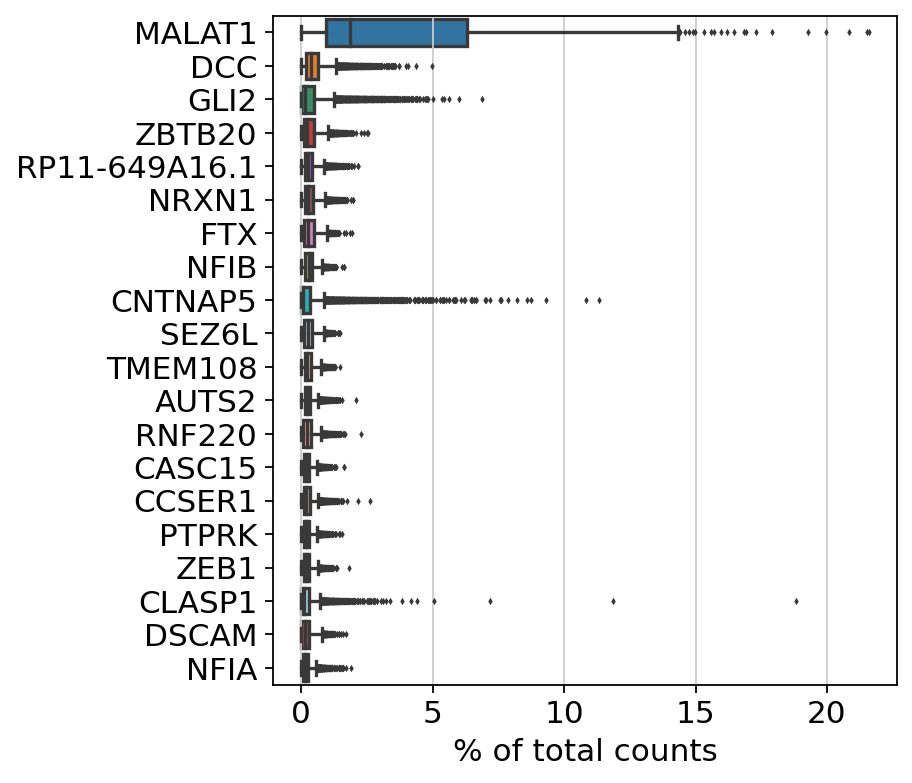

In [34]:
# preprocessing
sc.pl.highest_expr_genes(adata, n_top=20,)

In [35]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


filtered out 7671 genes that are detected in less than 3 cells


In [36]:
# calculate some quality metrics as for instance mitochondrial percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# and for ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'patient' as categorical
... storing 'feature_types' as categorical


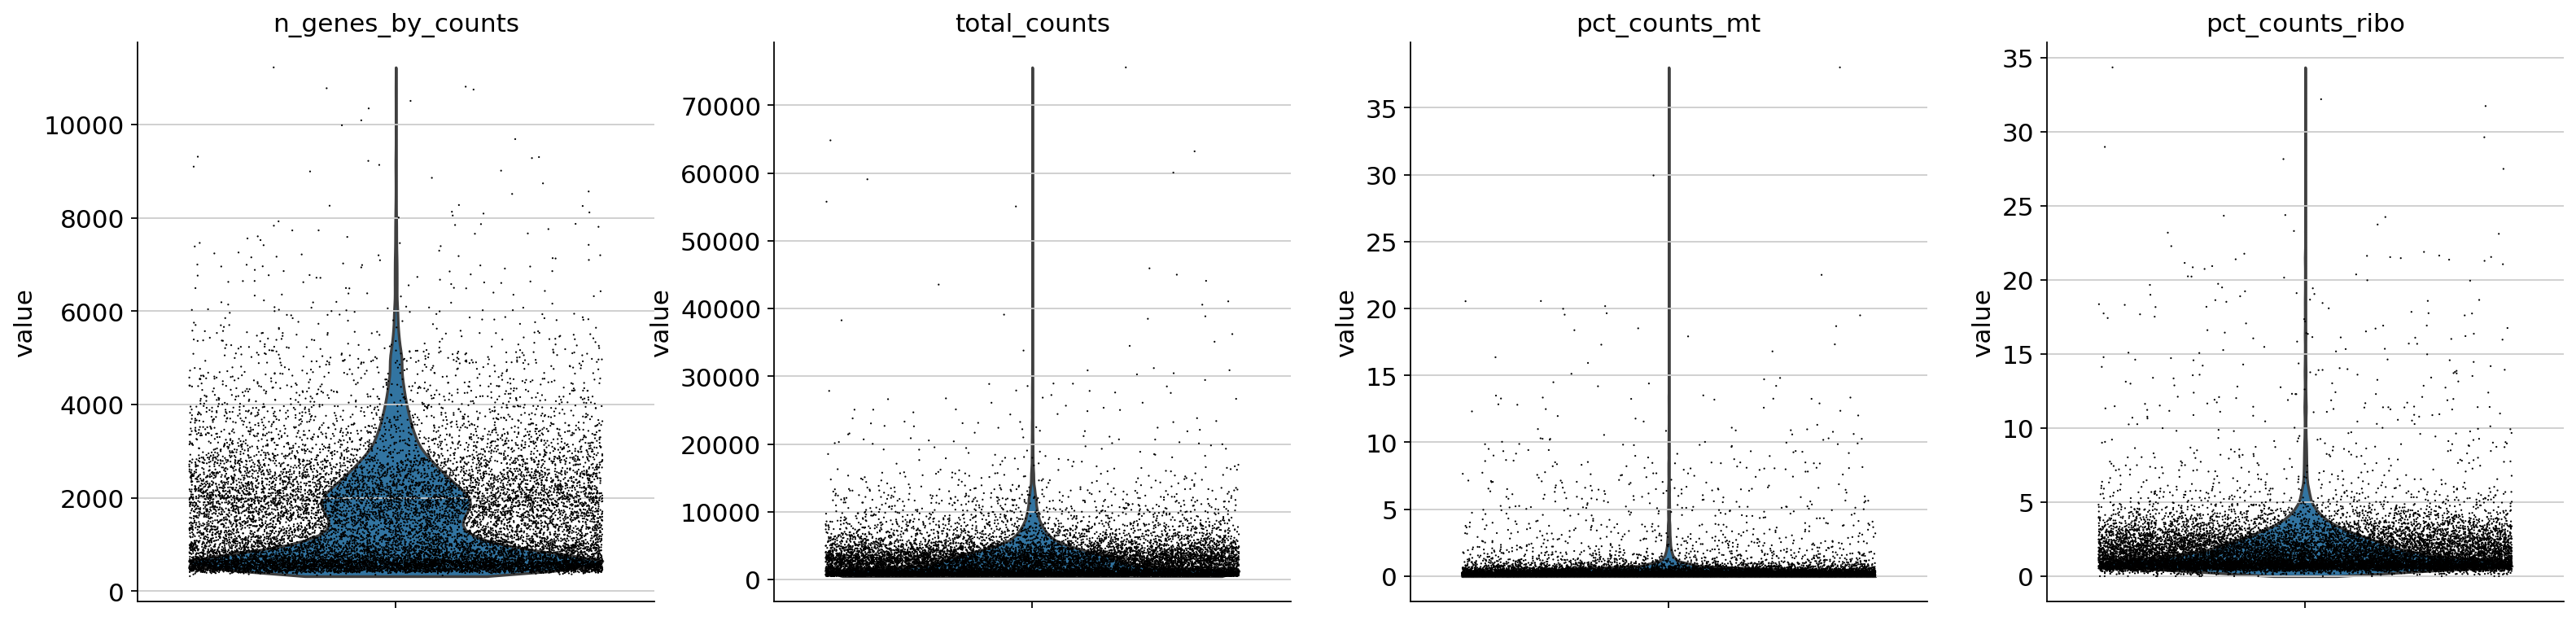

In [37]:
# visualize some QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

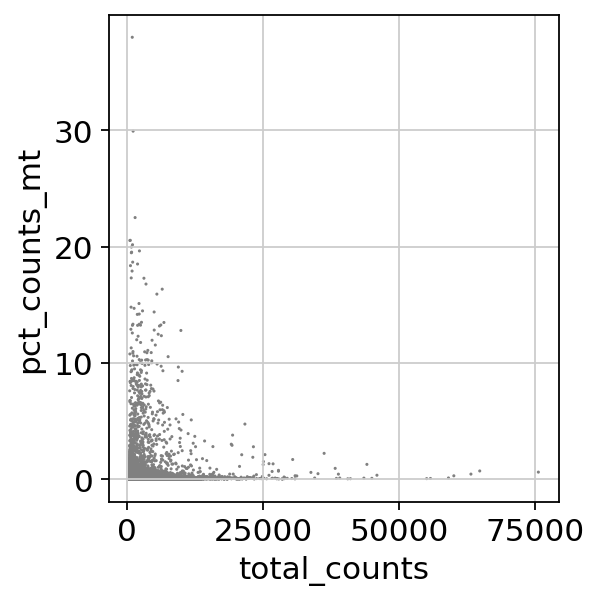

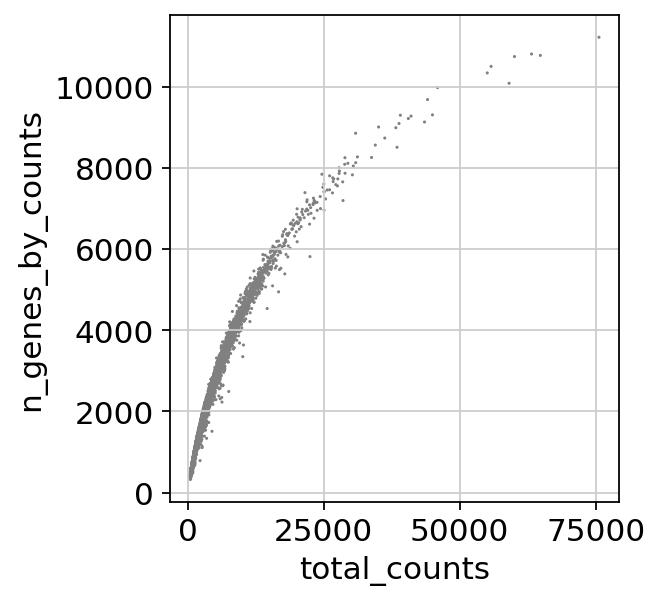

In [38]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [39]:
# do the actual filtering by slicing the object
adata = adata[300 < adata.obs.n_genes_by_counts, :]
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[500 < adata.obs.total_counts, :]
adata = adata[adata.obs.total_counts < 25000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata = adata[adata.obs.pct_counts_ribo < 10, :]

In [40]:
# check how many cells are leftover after the filtering
adata

View of AnnData object with n_obs × n_vars = 15265 × 25067
    obs: 'sample', 'technology', 'patient', 'scrublet__predicted_multiplet', 'scrublet__multiplet_scores', 'scrublet__multiplet_zscores', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

In [41]:
# calculate mean number of genes detected
mean_genes = adata.obs['n_genes'].mean()
print(mean_genes)

# calculate mean number of transcripts detected
mean_counts = adata.obs['total_counts'].mean()
print(mean_counts)

1523.0778905994105
2582.044921875


## PERFORM NORMALIZATION, PCA AND CLUSTERING

In [42]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [43]:
sc.pp.log1p(adata)

In [44]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


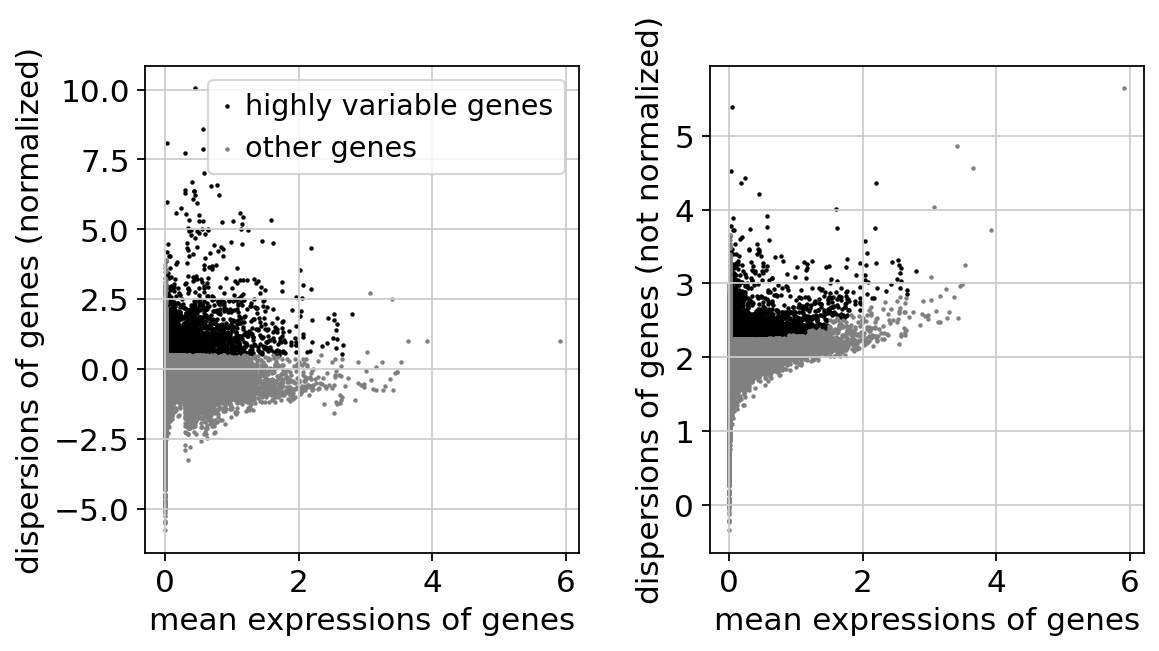

In [45]:
sc.pl.highly_variable_genes(adata)

In [46]:
# set the raw attribute of anndata
adata.raw = adata

In [47]:
adata = adata[:, adata.var.highly_variable]

In [48]:
# regress out effects of total counts per cell and the percentage of mitochondrial genes
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:00:51)


In [49]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:15)


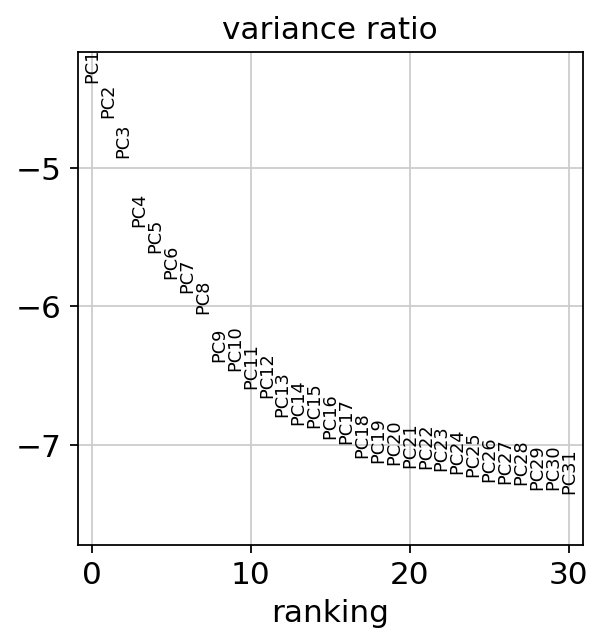

In [50]:
sc.pl.pca_variance_ratio(adata, log=True)

In [51]:
# compute nearest neighbors, UMAP and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)
sc.tl.umap(adata, n_components=2, min_dist=0.1,  # Scanpy default = 0.05
           spread=1.0, copy=False, random_state=0)
sc.tl.louvain(adata, resolution= 0.3)
sc.tl.leiden(adata, resolution= 0.3)

computing neighbors
    using 'X_pca' with n_pcs = 15


/home/przybilm/.local/lib/python3.7/site-packages/numba/core/typed_passes.py:332: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/przybilm/.local/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.local/lib/python3.7/site-packages/umap/utils.py", line 4

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


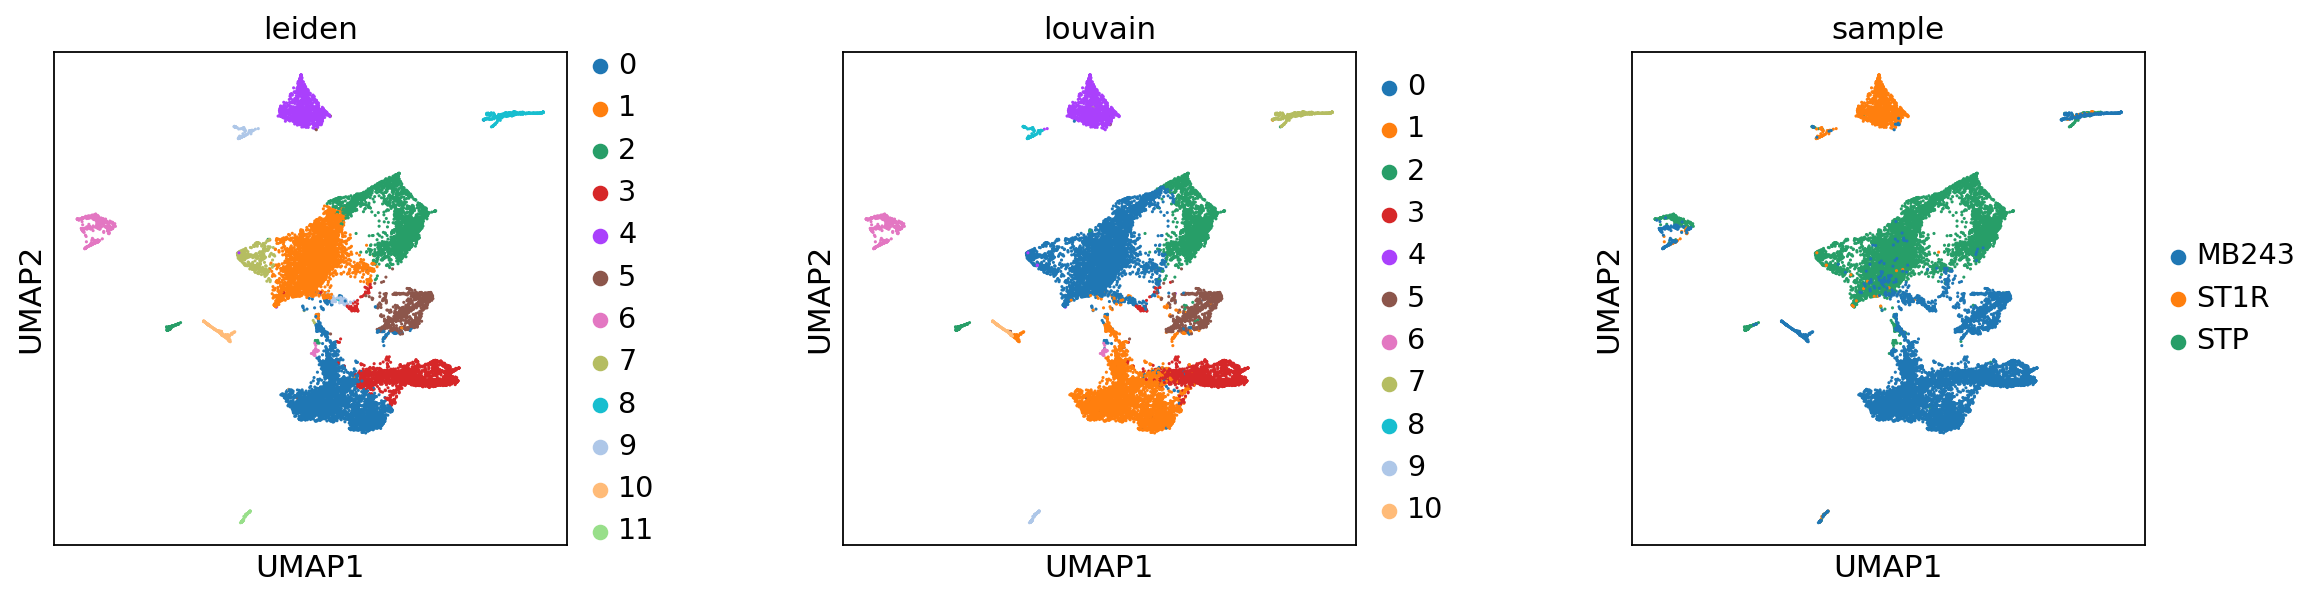

In [52]:
sc.pl.umap(adata, color=['leiden', 'louvain', "sample"], wspace = 0.4)

In [53]:
pd.crosstab(adata.obs['leiden'], adata.obs['sample'])

sample  MB243  ST1R   STP
leiden                   
0        3695     2    51
1         154    13  3493
2          10     1  2273
3        1822     0     2
4           6  1130     2
5         936     1    10
6         163    29   280
7           2     2   388
8         222    33    86
9          95    83    24
10        161     0     0
11         35    35    26

In [54]:
adata.write(results_file)  # the file that will store the analysis results)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [55]:
# adata = sc.read(results_file)

In [56]:
adata.obs

sample technology patient  scrublet__predicted_multiplet  \
AAACCTGCACATCCAA-1-0    STP     Nuclei      ST                          False   
AAACCTGCACTAGTAC-1-0    STP     Nuclei      ST                          False   
AAACCTGCATCATCCC-1-0    STP     Nuclei      ST                          False   
AAACCTGGTAGCGATG-1-0    STP     Nuclei      ST                          False   
AAACCTGGTAGCTCCG-1-0    STP     Nuclei      ST                          False   
...                     ...        ...     ...                            ...   
TTTGTCAGTTCCTCCA-1-2  MB243     Nuclei   MB243                          False   
TTTGTCATCAATCACG-1-2  MB243     Nuclei   MB243                          False   
TTTGTCATCCCAACGG-1-2  MB243     Nuclei   MB243                          False   
TTTGTCATCGCTTGTC-1-2  MB243     Nuclei   MB243                          False   
TTTGTCATCTATGTGG-1-2  MB243     Nuclei   MB243                          False   

                      scrublet__multiplet_scores  scrublet__multiplet_zscores  \
AAACCTGCACATCCAA-1-0                    0.215768                    -9.569958   
AAACCTGCACTAGTAC-1-0                    0.134111                   -17.467151   
AAACCTGCATCATCCC-1-0                    0.081828                   -30.576015   
AAACCTGGTAGCGATG-1-0                    0.248260                    -7.865708   
AAACCTGGTAGCTCCG-1-0                    0.155340                   -14.623827   
...                                          ...                          ...   
TTTGTCAGTTCCTCCA-1-2                    0.187500                    -8.151105   
TTTGTCATCAATCACG-1-2                    0.090526                   -20.546005   
TTTGTCATCCCAACGG-1-2                    0.220472                    -6.393604   
TTTGTCATCGCTTGTC-1-2                    0.173770                    -9.076989   
TTTGTCATCTATGTGG-1-2                    0.055690                   -35.040172   

                     batch  n_genes  n_genes_by_counts  total_counts  \
AAACCTGCACATCCAA-1-0     0      521                520         660.0   
AAACCTGCACTAGTAC-1-0     0      567                566         753.0   
AAACCTGCATCATCCC-1-0     0      424                424         548.0   
AAACCTGGTAGCGATG-1-0     0     3130               3129        6149.0   
AAACCTGGTAGCTCCG-1-0     0      472                472         596.0   
...                    ...      ...                ...           ...   
TTTGTCAGTTCCTCCA-1-2     2     2020               2020        3162.0   
TTTGTCATCAATCACG-1-2     2     3786               3786        7859.0   
TTTGTCATCCCAACGG-1-2     2     2499               2499        4407.0   
TTTGTCATCGCTTGTC-1-2     2      924                924        1126.0   
TTTGTCATCTATGTGG-1-2     2     2997               2997        5907.0   

                      total_counts_mt  pct_counts_mt  total_counts_ribo  \
AAACCTGCACATCCAA-1-0              0.0       0.000000               19.0   
AAACCTGCACTAGTAC-1-0              2.0       0.265604                9.0   
AAACCTGCATCATCCC-1-0              3.0       0.547445               36.0   
AAACCTGGTAGCGATG-1-0              7.0       0.113840               83.0   
AAACCTGGTAGCTCCG-1-0              1.0       0.167785               12.0   
...                               ...            ...                ...   
TTTGTCAGTTCCTCCA-1-2              2.0       0.063251               27.0   
TTTGTCATCAATCACG-1-2              5.0       0.063621               40.0   
TTTGTCATCCCAACGG-1-2              5.0       0.113456               28.0   
TTTGTCATCGCTTGTC-1-2              2.0       0.177620               10.0   
TTTGTCATCTATGTGG-1-2              9.0       0.152362               17.0   

                      pct_counts_ribo louvain leiden  
AAACCTGCACATCCAA-1-0         2.878788       0      1  
AAACCTGCACTAGTAC-1-0         1.195219       0      1  
AAACCTGCATCATCCC-1-0         6.569343       0      1  
AAACCTGGTAGCGATG-1-0         1.349813       2      2  
AAACCTGGTAGCTCCG-1-0         2.013

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:33)


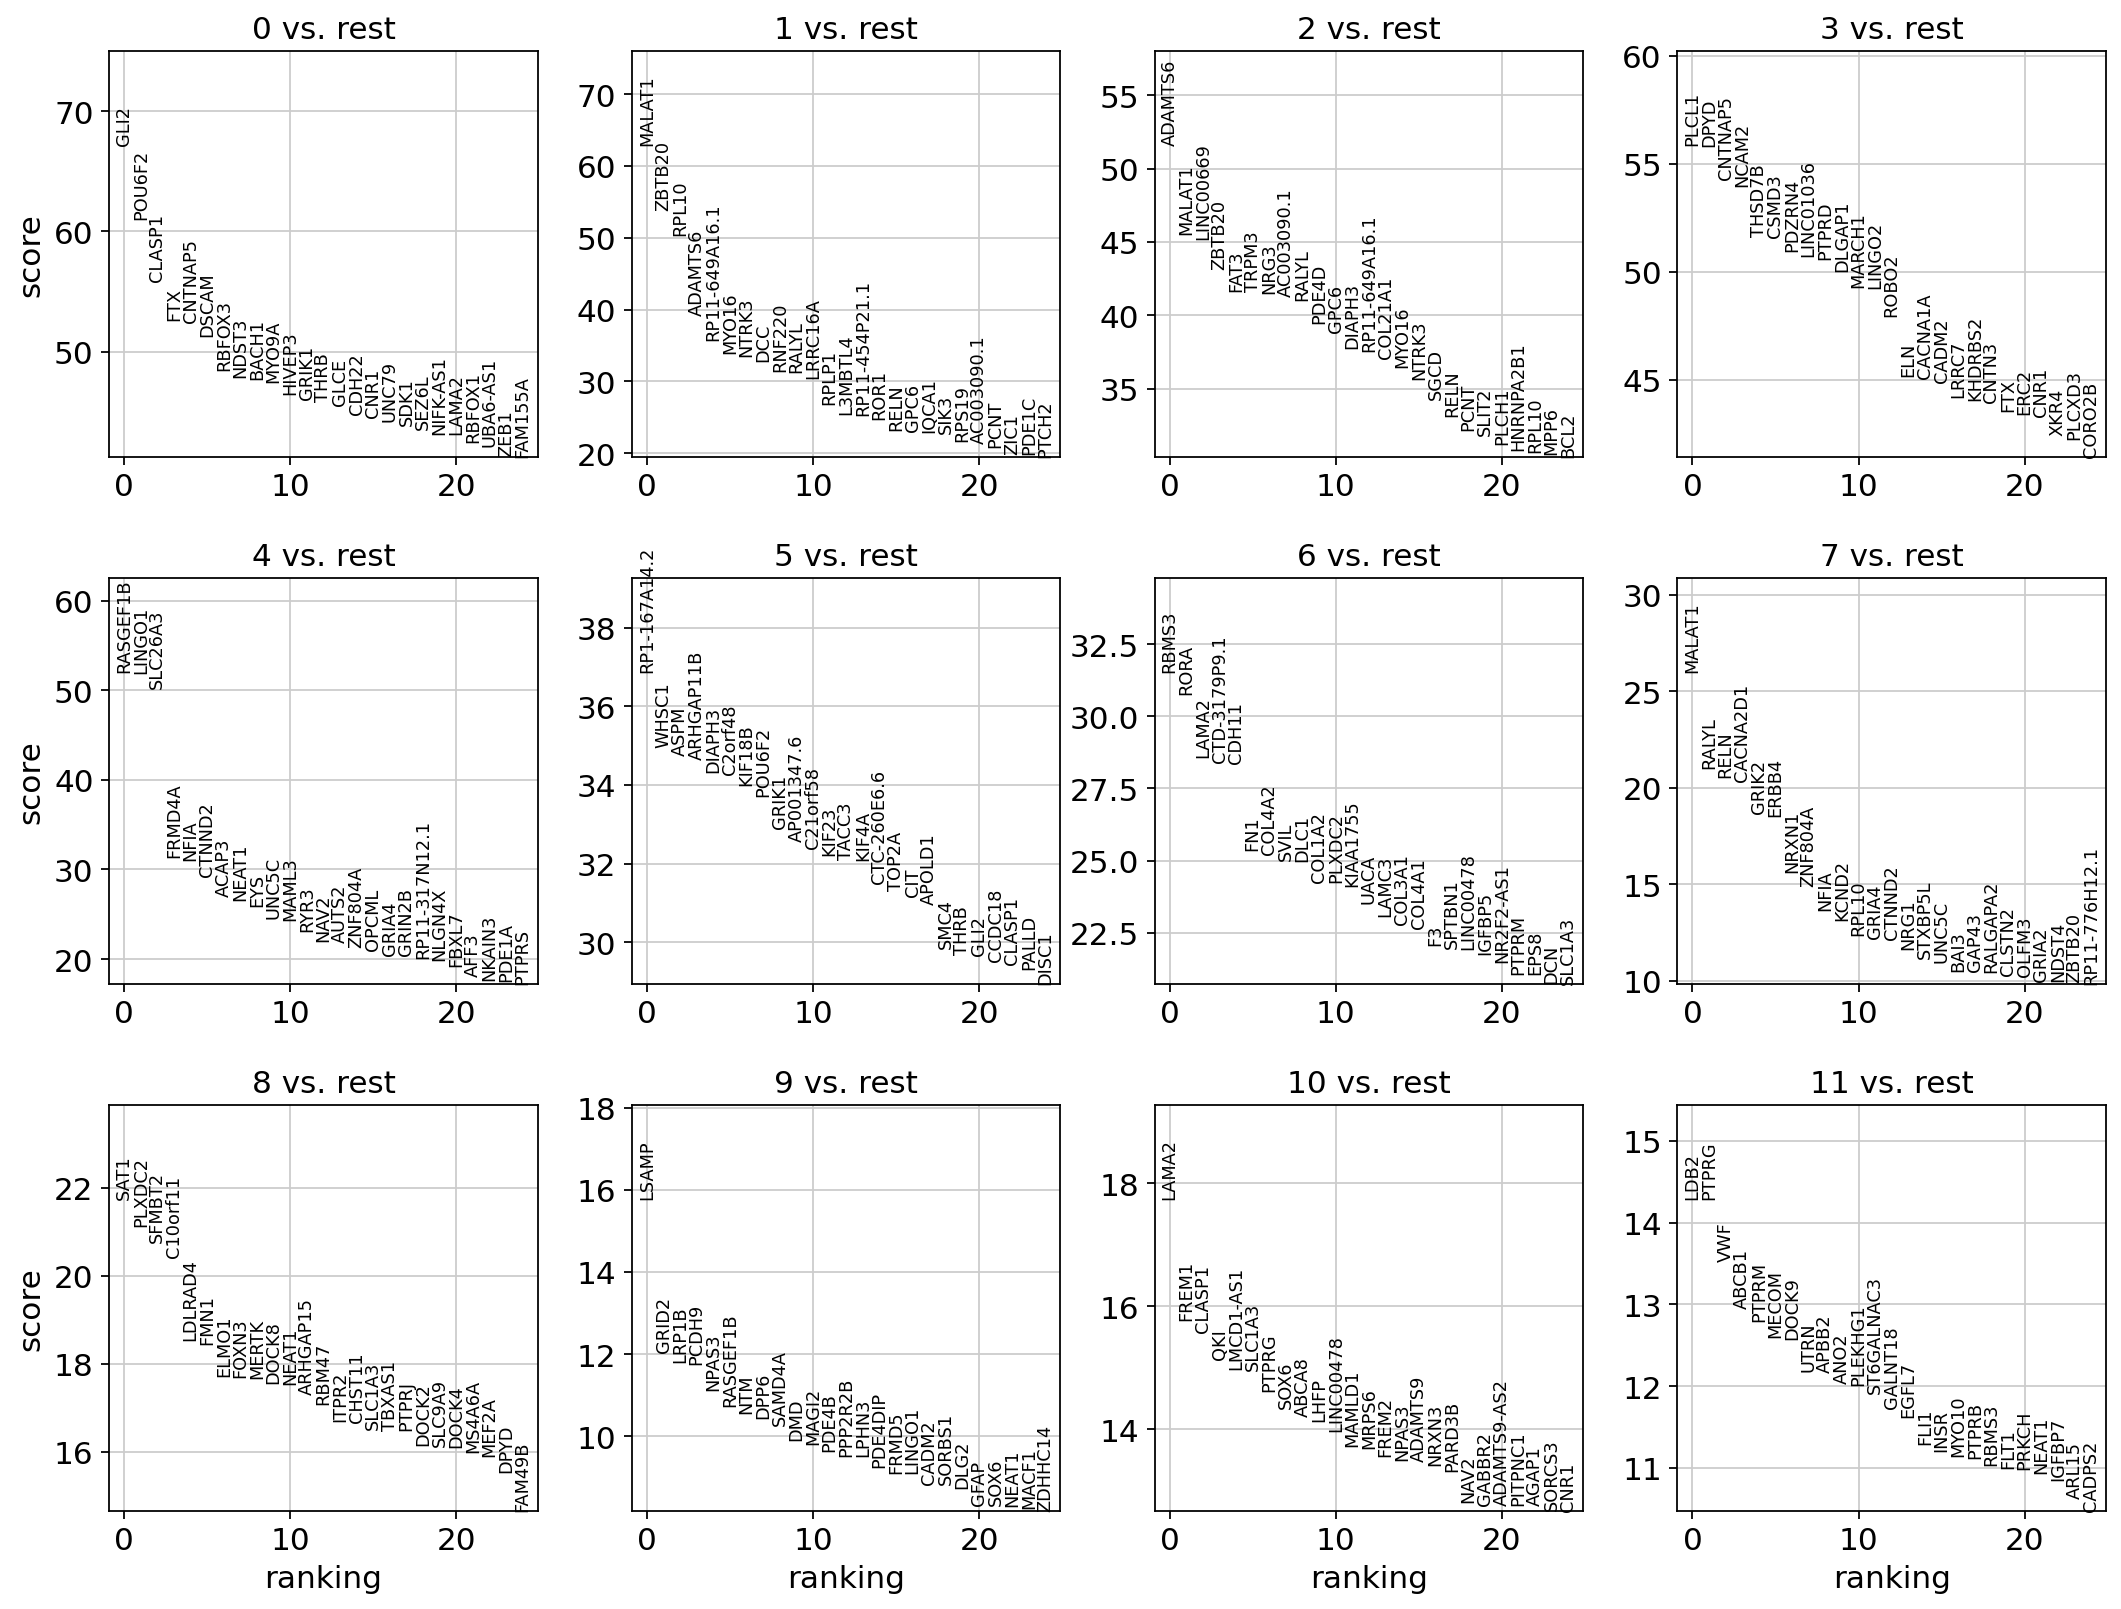

In [57]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = "_nuclei.pdf")

In [58]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

0              1              2          3              4  \
0       GLI2         MALAT1        ADAMTS6      PLCL1       RASGEF1B   
1     POU6F2         ZBTB20         MALAT1       DPYD         LINGO1   
2     CLASP1          RPL10      LINC00669    CNTNAP5        SLC26A3   
3        FTX        ADAMTS6         ZBTB20      NCAM2         FRMD4A   
4    CNTNAP5  RP11-649A16.1           FAT3     THSD7B           NFIA   
5      DSCAM          MYO16          TRPM3      CSMD3         CTNND2   
6     RBFOX3          NTRK3           NRG3     PDZRN4          ACAP3   
7      NDST3            DCC     AC003090.1  LINC01036          NEAT1   
8      BACH1         RNF220          RALYL      PTPRD            EYS   
9      MYO9A          RALYL          PDE4D     DLGAP1          UNC5C   
10    HIVEP3        LRRC16A           GPC6     MARCH1          MAML3   
11     GRIK1          RPLP1         DIAPH3     LINGO2           RYR3   
12      THRB        L3MBTL4  RP11-649A16.1      ROBO2           NAV2   
13      GLCE  RP11-454P21.1        COL21A1        ELN          AUTS2   
14     CDH22           ROR1          MYO16    CACNA1A        ZNF804A   
15      CNR1           RELN          NTRK3      CADM2          OPCML   
16     UNC79           GPC6           SGCD      LRRC7          GRIA4   
17      SDK1          IQCA1           RELN    KHDRBS2         GRIN2B   
18     SEZ6L           SIK3           PCNT      CNTN3  RP11-317N12.1   
19  NIFK-AS1          RPS19          SLIT2        FTX         NLGN4X   

               5             6         7         8         9         10  \
0   RP1-167A14.2         RBMS3    MALAT1      SAT1     LSAMP      LAMA2   
1          WHSC1          RORA     RALYL    PLXDC2     GRID2      FREM1   
2           ASPM         LAMA2      RELN    SFMBT2     LRP1B     CLASP1   
3      ARHGAP11B  CTD-3179P9.1  CACNA2D1  C10orf11     PCDH9        QKI   
4         DIAPH3         CDH11     GRIK2   LDLRAD4     NPAS3  LMCD1-AS1   
5        C2orf48           FN1     ERBB4      FMN1  RASGEF1B     SLC1A3   
6         KIF18B        COL4A2     NRXN1     ELMO1       NTM      PTPRG   
7         POU6F2          SVIL   ZNF804A     FOXN3      DPP6       SOX6   
8          GRIK1          DLC1      NFIA     MERTK    SAMD4A      ABCA8   
9     AP001347.6        COL1A2     KCND2     DOCK8       DMD       LHFP   
10      C21orf58        PLXDC2     RPL10     NEAT1     MAGI2  LINC00478   
11         KIF23      KIAA1755     GRIA4  ARHGAP15     PDE4B     MAMLD1   
12         TACC3          UACA    CTNND2     RBM47   PPP2R2B      MRPS6   
13         KIF4A         LAMC3      NRG1     ITPR2     LPHN3      FREM2   
14   CTC-260E6.6        COL3A1   STXBP5L    CHST11   PDE4DIP      NPAS3   
15         TOP2A        COL4A1     UNC5C    SLC1A3     FRMD5    ADAMTS9   
16           CIT            F3      BAI3    TBXAS1    LINGO1      NRXN3   
17        APOLD1        SPTBN1     GAP43     PTPRJ     CADM2     PARD3B   
18          SMC4     LINC00478  RALGAPA2     DOCK2    SORBS1       NAV2   
19          THRB        IGFBP5    CLSTN2    SLC9A9      DLG2     GABBR2   

            11  
0         LDB2  
1        PTPRG  
2          VWF  
3        ABCB1  
4        PTPRM  
5        MECOM  
6        DOCK9  
7         UTRN  
8        APBB2  
9         ANO2  
10     PLEKHG1  
11  ST6GALNAC3  
12     GALNT18  
13       EGFL7  
14        FLI1  
15        INSR  
16       MYO10  
17       PTPRB  
18       RBMS3  
19        FLT1

In [59]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', "scores", 'logfoldchanges', "pvals", 'pvals_adj']})

In [60]:
# write DEG to file
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/Nuclei_DEG_wilcoxon.csv")

In [61]:
new_cluster_names = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6','cluster7', 'cluster8', 'cluster9', 'cluster10', 'cluster11']
adata.rename_categories('leiden', new_cluster_names)

old_to_new = dict(
    cluster0='Malignant SHH I',
    cluster1='Malignant SHH II',
    cluster2='Malignant SHH II',
    cluster3='Malignant Neuronal Development I',
    cluster4='Malignant Neuronal Development II',
    cluster5='Malignant Cycling',
    cluster6='Meninge Cells',
    cluster7='Malignant SHH II',
    cluster8='Macrophages',
    cluster9='Purkinje Cells',
    cluster10='Astrocytes',
    cluster11='Endothelial Cells'
)
  
adata.obs['Cell_types'] = (
    adata.obs['leiden']
    .map(old_to_new)
    .astype('category')
)


/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


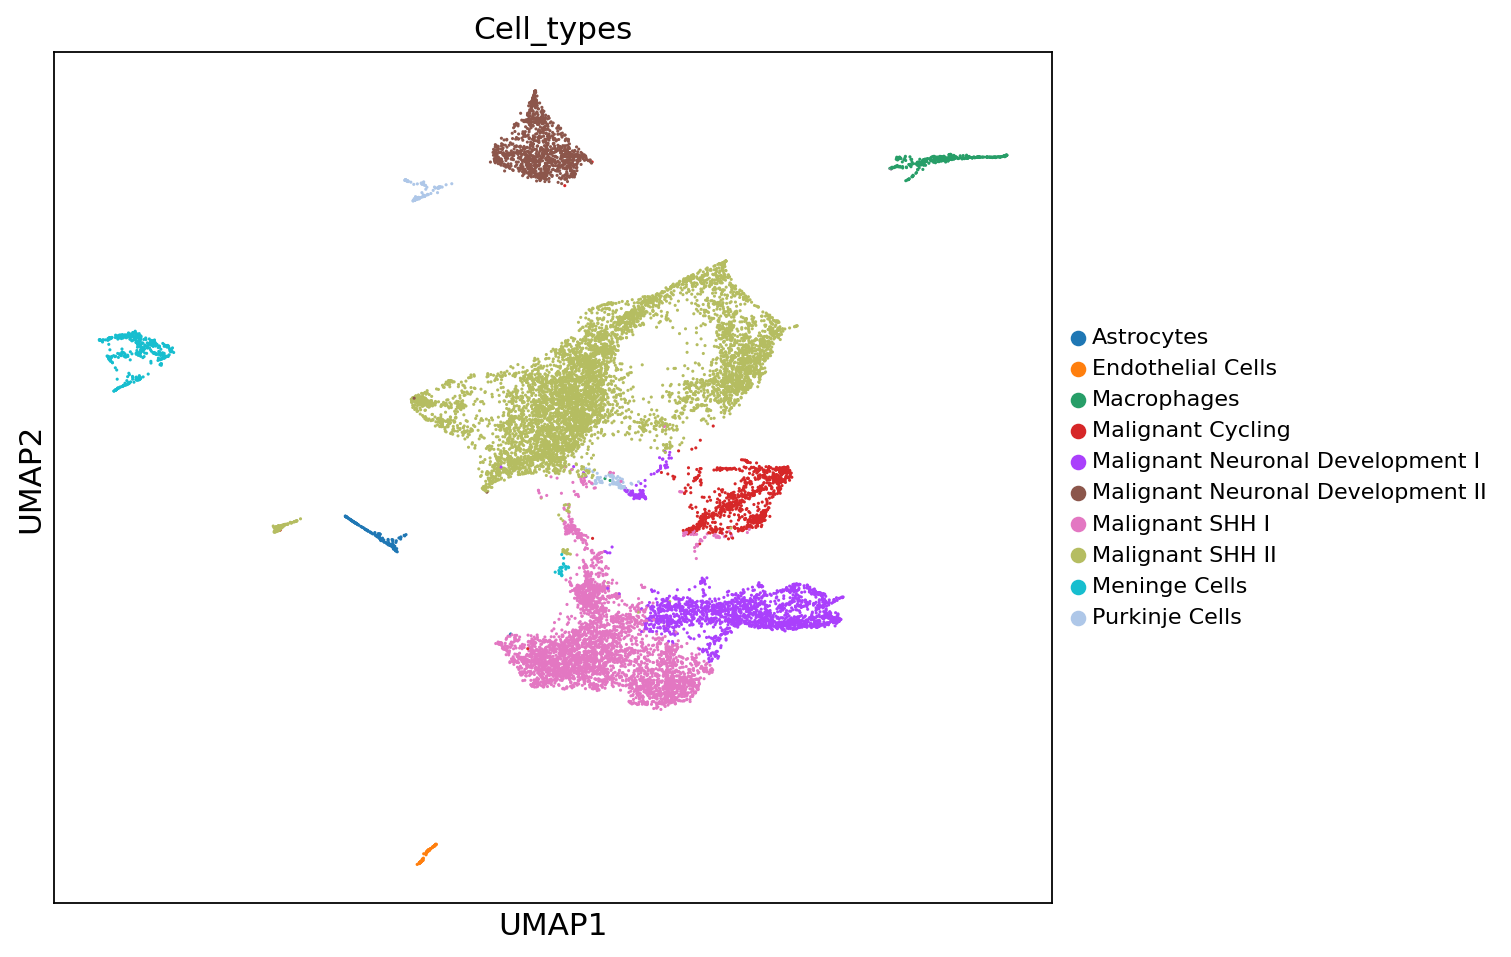

In [62]:
rcParams['figure.figsize'] = 8,7
sc.pl.umap(adata, color=['Cell_types'], save = '_Nuclei_CellType_Figure2.pdf', legend_fontsize = 10)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


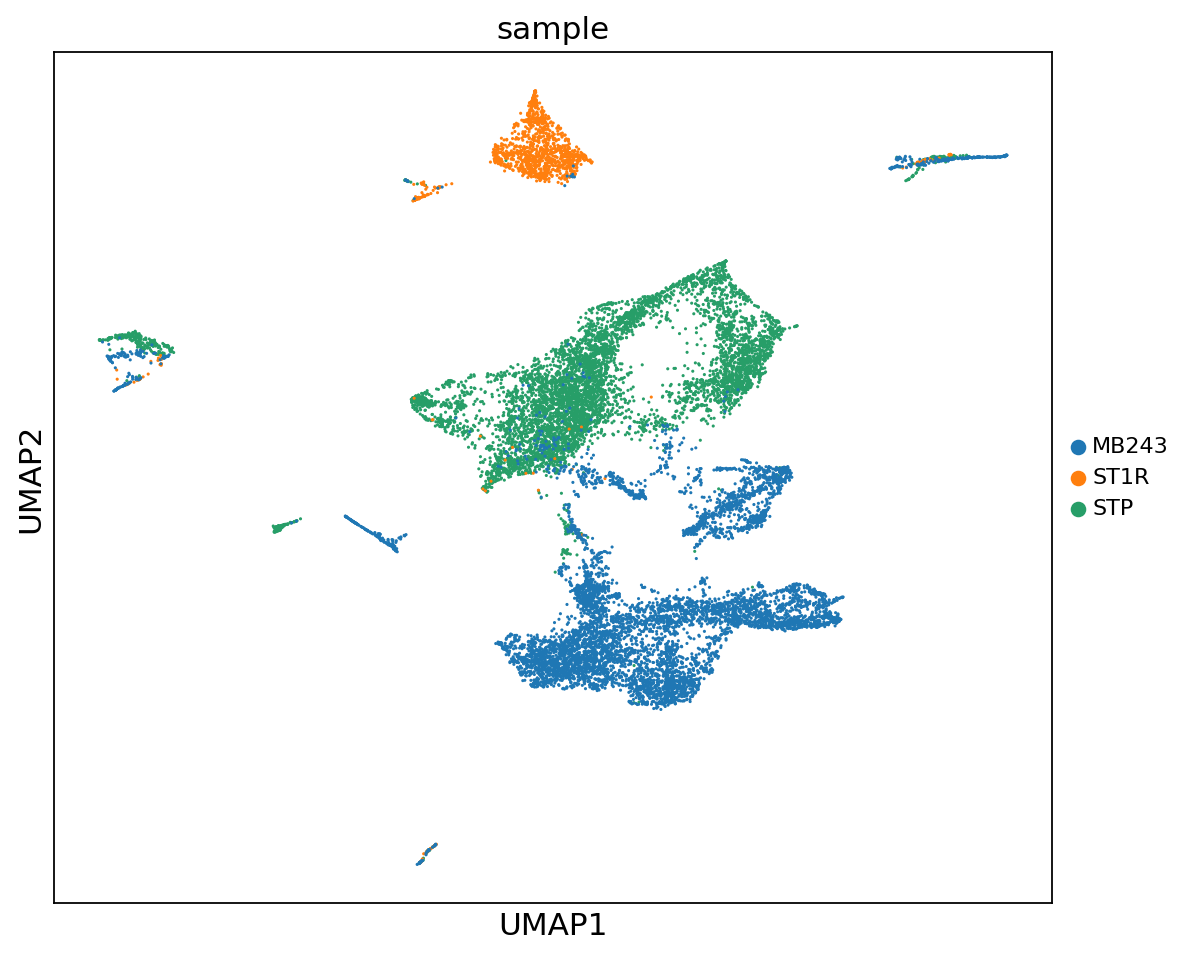

In [63]:
rcParams['figure.figsize'] = 8,7
sc.pl.umap(adata, color=['sample'], save = '_Nuclei_Sample_Supplementary_Figure.pdf', legend_fontsize = 10)

In [64]:
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/Nuclei_metadata_final.csv')

In [65]:
adata.write_csvs("/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/Nuclei_expression", skip_data=False)

writing .csv files to /icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/Nuclei_expression


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


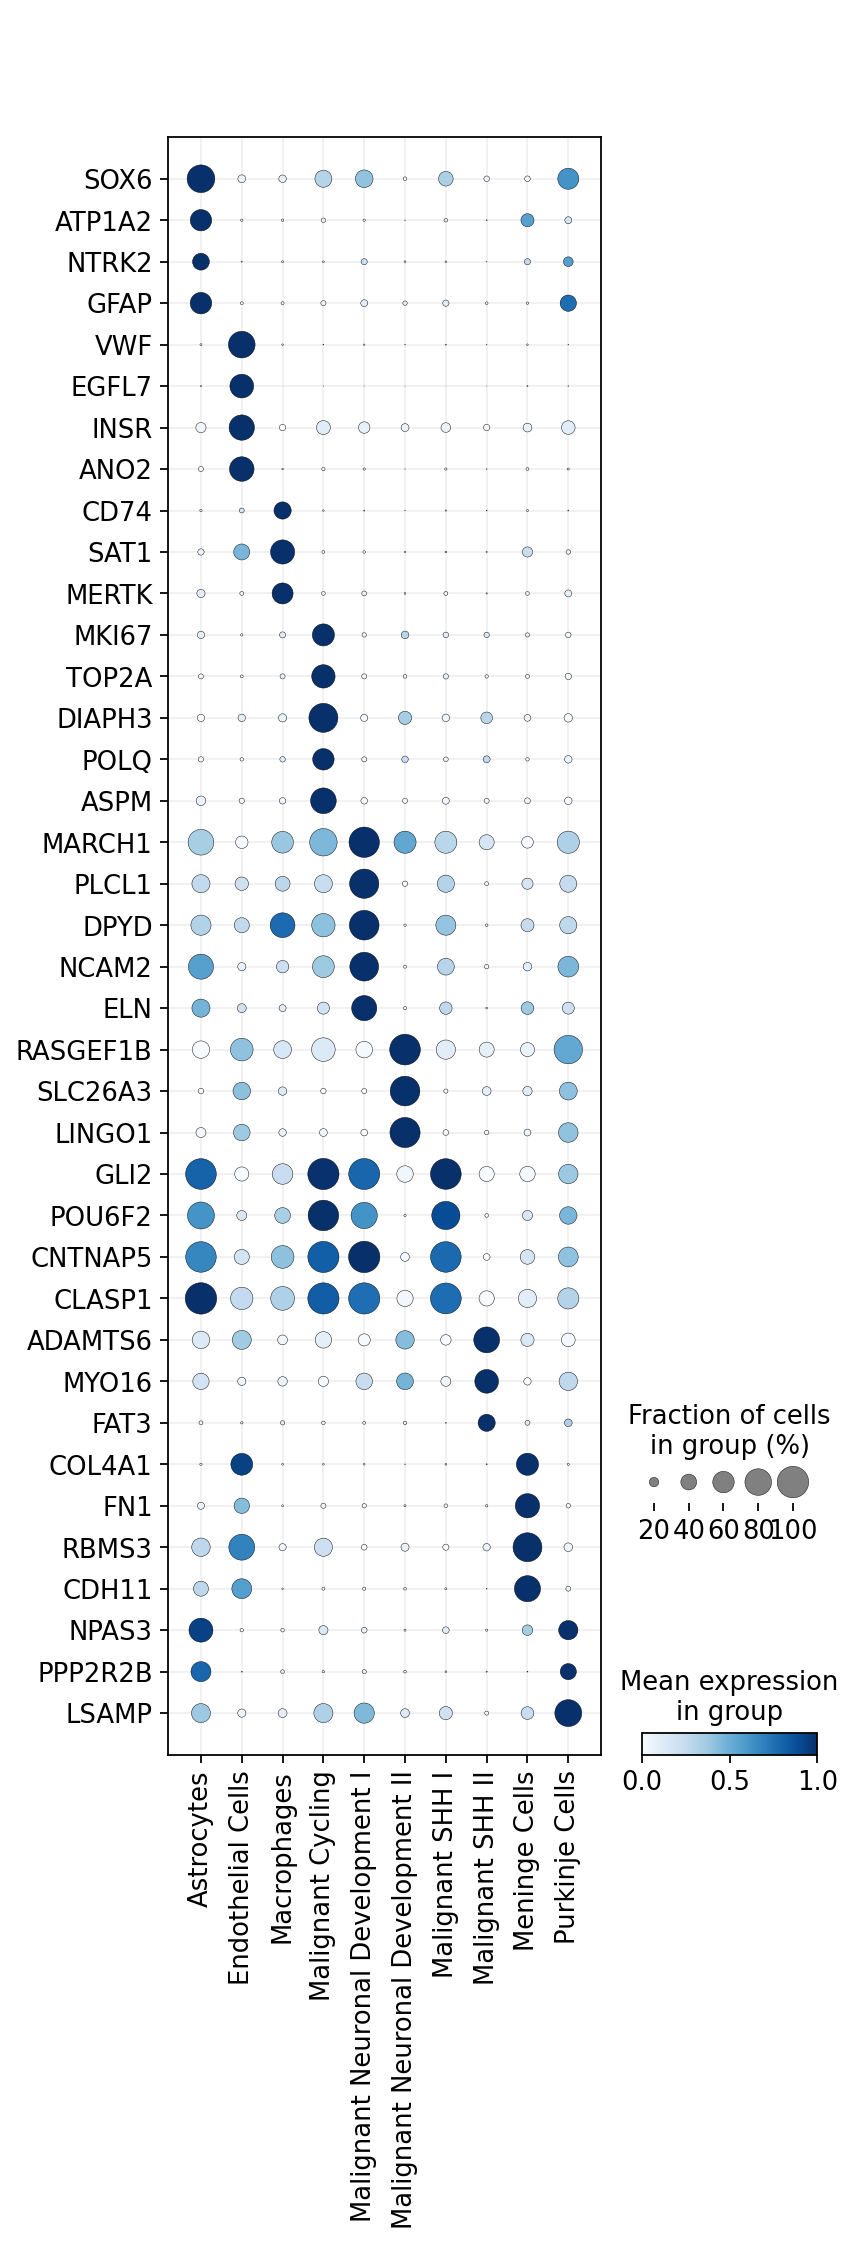

In [66]:
aurelie_celltype_genes = ['SOX6', "ATP1A2", "NTRK2", 'GFAP', # Astrocytes
                          "VWF", "EGFL7", 'INSR', 'ANO2', # Endothelial cells
                          "CD74", "SAT1", "MERTK", # Macrophages
                          "MKI67", "TOP2A", "DIAPH3", "POLQ", 'ASPM', # Malignant Cycling
                          'MARCH1', 'PLCL1', 'DPYD', "NCAM2", "ELN", # Malignant Neuronal Development I
                          'RASGEF1B', 'SLC26A3','LINGO1',  # Malignant Neuronal Development II
                          "GLI2", "POU6F2", 'CNTNAP5', 'CLASP1', "ADAMTS6", "MYO16", "FAT3", # Malignant SHH I & II
                          "COL4A1", "FN1", 'RBMS3', 'CDH11', # Meninge Cells
                          'NPAS3', 'PPP2R2B', 'LSAMP'] # Purkinje Cells


sc.pl.dotplot(adata, aurelie_celltype_genes, groupby='Cell_types', standard_scale='var', return_fig=True).style(grid=True, cmap='Blues', color_on='dot').swap_axes(swap_axes=True).savefig("Nuclei_Celltype_MarkerGenes_Figure2.pdf")

In [67]:
adata.write('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/adata_nuclei_Celltype.h5ad')  # the file that will store the analysis results)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:33)


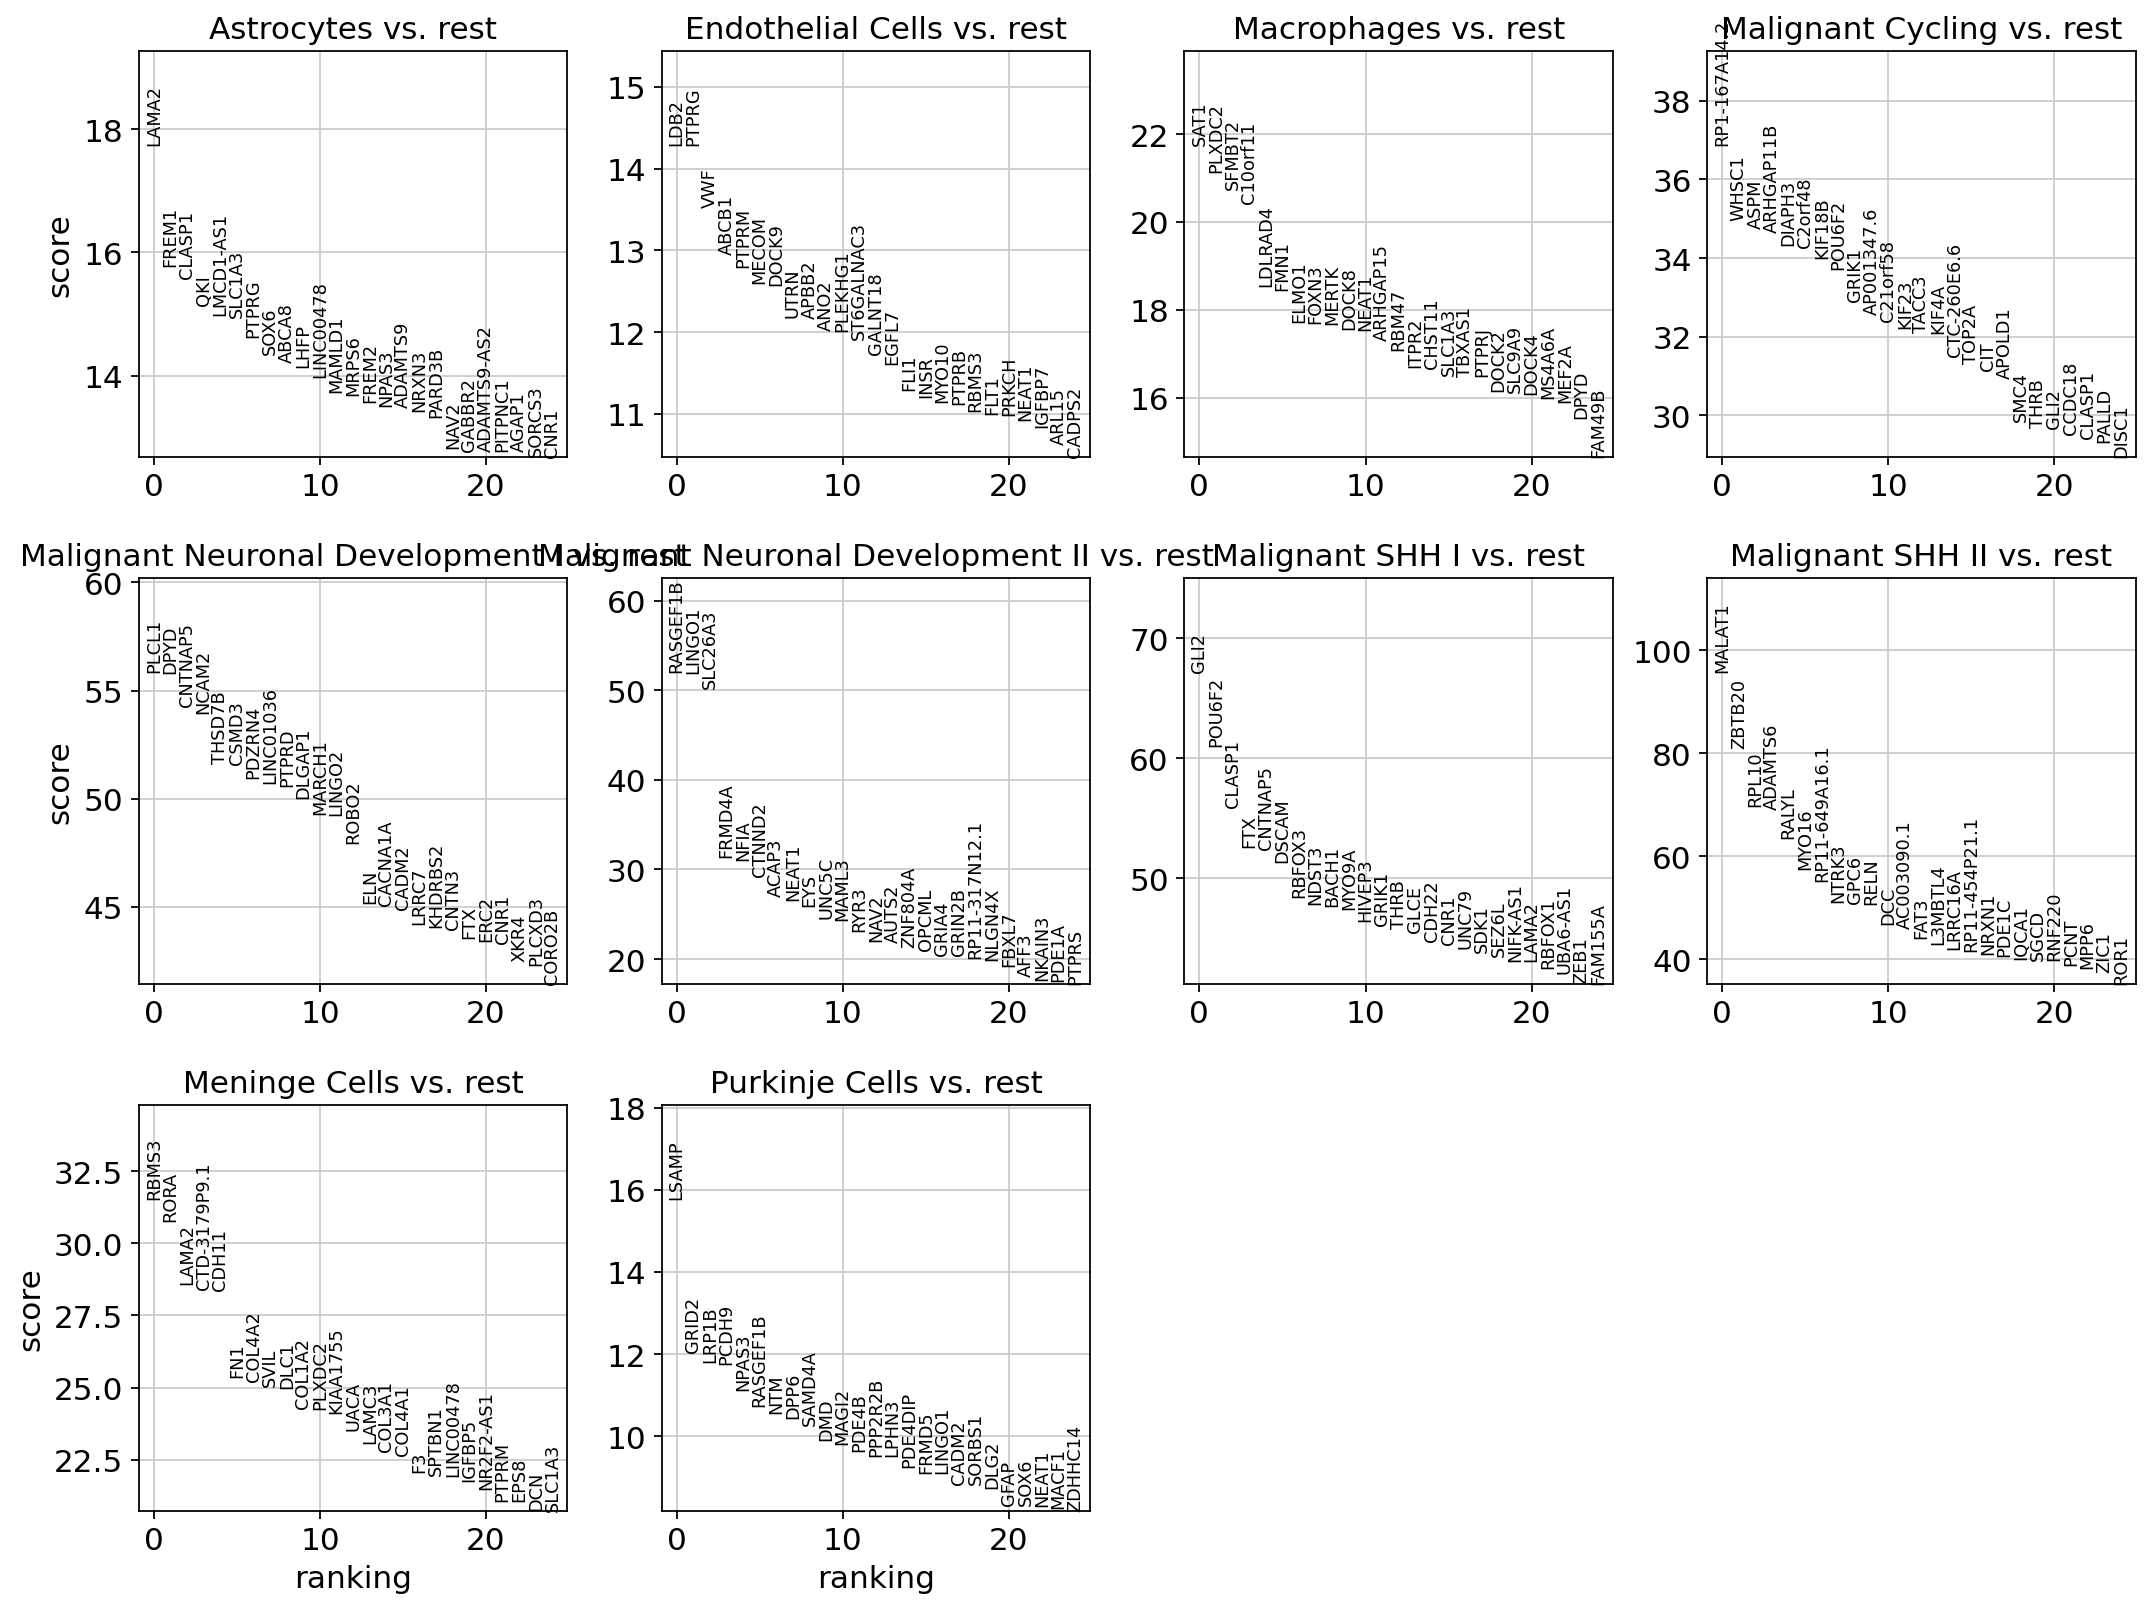

In [169]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(adata, 'Cell_types', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = "_Celltypes_nuclei.pdf")

In [170]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

Astrocytes Endothelial Cells Macrophages Malignant Cycling  \
0       LAMA2              LDB2        SAT1      RP1-167A14.2   
1       FREM1             PTPRG      PLXDC2             WHSC1   
2      CLASP1               VWF      SFMBT2              ASPM   
3         QKI             ABCB1    C10orf11         ARHGAP11B   
4   LMCD1-AS1             PTPRM     LDLRAD4            DIAPH3   
5      SLC1A3             MECOM        FMN1           C2orf48   
6       PTPRG             DOCK9       ELMO1            KIF18B   
7        SOX6              UTRN       FOXN3            POU6F2   
8       ABCA8             APBB2       MERTK             GRIK1   
9        LHFP              ANO2       DOCK8        AP001347.6   
10  LINC00478           PLEKHG1       NEAT1          C21orf58   
11     MAMLD1        ST6GALNAC3    ARHGAP15             KIF23   
12      MRPS6           GALNT18       RBM47             TACC3   
13      FREM2             EGFL7       ITPR2             KIF4A   
14      NPAS3              FLI1      CHST11       CTC-260E6.6   
15    ADAMTS9              INSR      SLC1A3             TOP2A   
16      NRXN3             MYO10      TBXAS1               CIT   
17     PARD3B             PTPRB       PTPRJ            APOLD1   
18       NAV2             RBMS3       DOCK2              SMC4   
19     GABBR2              FLT1      SLC9A9              THRB   

   Malignant Neuronal Development I Malignant Neuronal Development II  \
0                             PLCL1                          RASGEF1B   
1                              DPYD                            LINGO1   
2                           CNTNAP5                           SLC26A3   
3                             NCAM2                            FRMD4A   
4                            THSD7B                              NFIA   
5                             CSMD3                            CTNND2   
6                            PDZRN4                             ACAP3   
7                         LINC01036                             NEAT1   
8                             PTPRD                               EYS   
9                            DLGAP1                             UNC5C   
10                           MARCH1                             MAML3   
11                           LINGO2                              RYR3   
12                            ROBO2                              NAV2   
13                              ELN                             AUTS2   
14                          CACNA1A                           ZNF804A   
15                            CADM2                             OPCML   
16                            LRRC7                             GRIA4   
17                          KHDRBS2                            GRIN2B   
18                            CNTN3                     RP11-317N12.1   
19                              FTX                            NLGN4X   

   Malignant SHH I Malignant SHH II Meninge Cells Purkinje Cells  
0             GLI2           MALAT1         RBMS3          LSAMP  
1           POU6F2           ZBTB20          RORA          GRID2  
2           CLASP1            RPL10         LAMA2          LRP1B  
3              FTX          ADAMTS6  CTD-3179P9.1          PCDH9  
4          CNTNAP5            RALYL         CDH11          NPAS3  
5            DSCAM            MYO16           FN1       RASGEF1B  
6           RBFOX3    RP11-649A16.1        COL4A2            NTM  
7            NDST3            NTRK3          SVIL           DPP6  
8            BACH1             GPC6          DLC1         SAMD4A  
9            MYO9A             RELN        COL1A2            DMD  
10          HIVEP3              DCC        PLXDC2          MAGI2  
11           GRIK1       AC003090.1      KIAA1755          PDE4B  
12            THRB             FAT3          UACA        PPP2R2B  
13            GLCE          L3MBTL4         LAMC3          LPHN3  
14           CDH22          LRRC16A        COL3A1        PDE4DIP  
15            CNR1    RP11-454P

In [171]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', "scores", 'logfoldchanges', "pvals", 'pvals_adj']})

In [172]:
# write DEG to file
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/Nuclei_Celltypes_DEG_wilcoxon.csv")

## RUN SCCAF TO VALIDATE THE CLUSTER NUMBER

In [175]:
# run sccaf on the clustering
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['Cell_types'], n=100)

Mean CV accuracy: 0.8675
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.7764


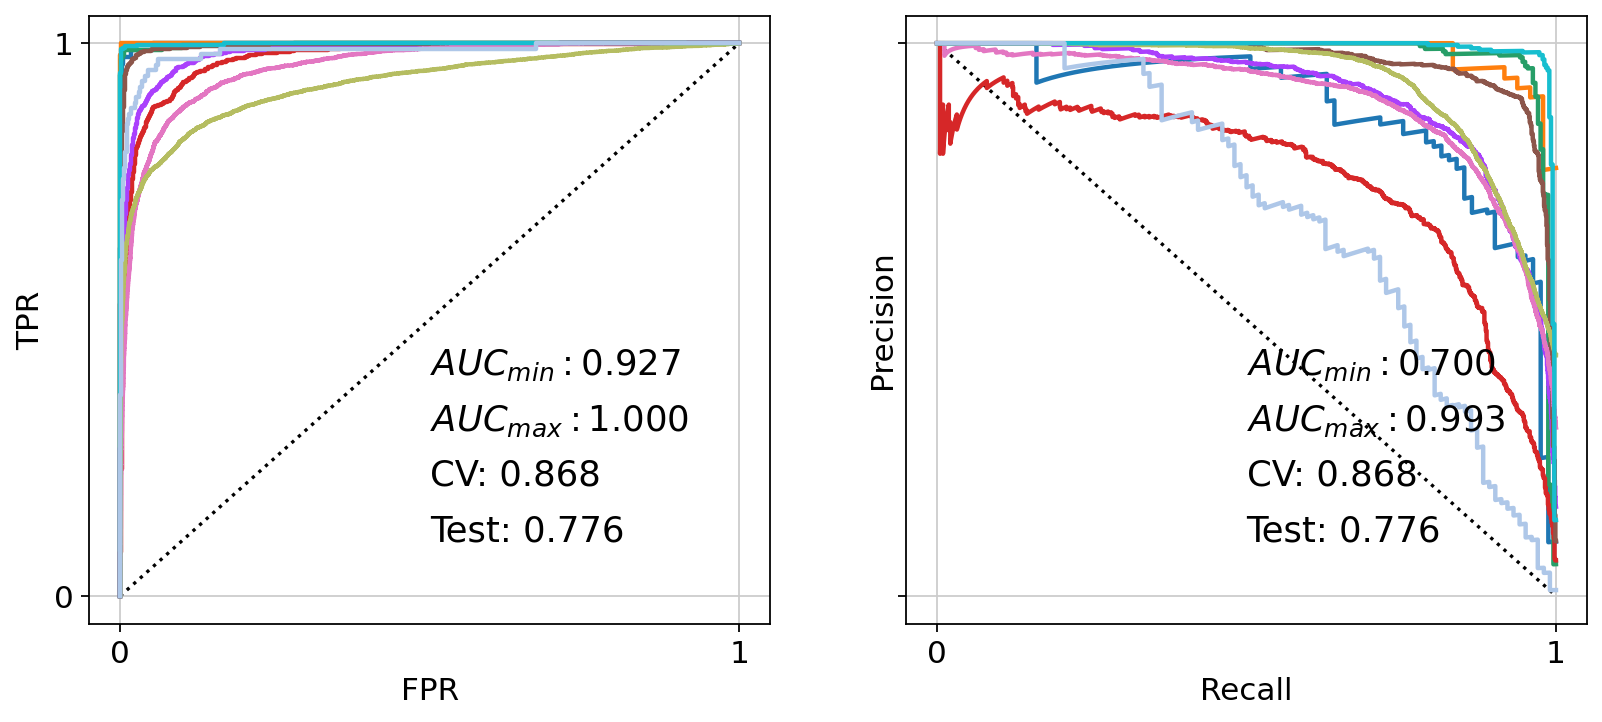

In [180]:
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 12,5
plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.savefig('/home/przybilm/jupyter/Nuclei/figures/sccaf_performance_Nuclei.pdf',  dpi=600, format='pdf')

In [157]:
# An initial over-clustering needs to be assigned in consistent with the prefix for the optimization.
# i.e., the optimization prefix is `L2`, the starting point of the optimization of `%s_Round0`%prefix, which is `L2_Round0`.

sc.tl.leiden(adata, resolution=0.6, key_added='L2_Round0')
# i.e., we aim to achieve an accuracy >90% for the whole dataset, optimize based on the PCA space:
SCCAF_optimize_all(ad=adata, plot = True, min_acc=0.85, prefix = 'L2', use='pca')

running Leiden clustering
    finished: found 16 clusters and added
    'L2_Round0', the cluster labels (adata.obs, categorical) (0:00:09)
R1norm_cutoff: 0.500000
R2norm_cutoff: 0.050000
Accuracy: 0.000000
Round1 ...
Mean CV accuracy: 0.8884
Accuracy on the training set: 0.9495
Accuracy on the hold-out set: 0.8403
Accuracy on the training set: 0.9429
Accuracy on the hold-out set: 0.8445
Accuracy on the training set: 0.9396
Accuracy on the hold-out set: 0.8482
Max R1mat: 0.863248
Max R2mat: 0.023274
min_acc: 0.840323
IGRAPH U-W- 16 2 --
+ attr: weight (e)
+ edges:
0--12 0--12
Round2 ...
Mean CV accuracy: 0.8905
Accuracy on the training set: 0.9495
Accuracy on the hold-out set: 0.8607
Accuracy on the training set: 0.9502
Accuracy on the hold-out set: 0.8568
Accuracy on the training set: 0.9445
Accuracy on the hold-out set: 0.8514
Max R1mat: 0.283262
Max R2mat: 0.023128
Converge SCCAF_optimize min_acc!
m1: 0.283262
m2: 0.023128
Accuracy: 0.851432


In [158]:
adata

AnnData object with n_obs × n_vars = 15265 × 4622
    obs: 'sample', 'technology', 'patient', 'scrublet__predicted_multiplet', 'scrublet__multiplet_scores', 'scrublet__multiplet_zscores', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'louvain', 'leiden', 'L2_Round1', 'L2_Round0', 'L2_Round0_self-projection', 'L2_result', 'L2_Round1_self-projection', 'L2_Round2', 'L2_Round2_self-projection', 'Upregulated_Chromothripsis_Score', 'Downregulated_Chromothripsis_Score', 'Cell_types', 'L2_Round3', 'L2_Round3_self-projection', 'L2_Round4', 'L2_Round4_self-projection', 'L2_Round5', 'L2_Round5_self-projection', 'L2_Round6', 'L2_Round6_self-projection', 'L2_Round7', 'L2_Round7_self-projection'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    u

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'L2_Round1' as categorical
... storing 'L2_Round0_self-projection' as categorical
... storing 'L2_result' as categorical
... storing 'L2_Round1_self-projection' as categorical


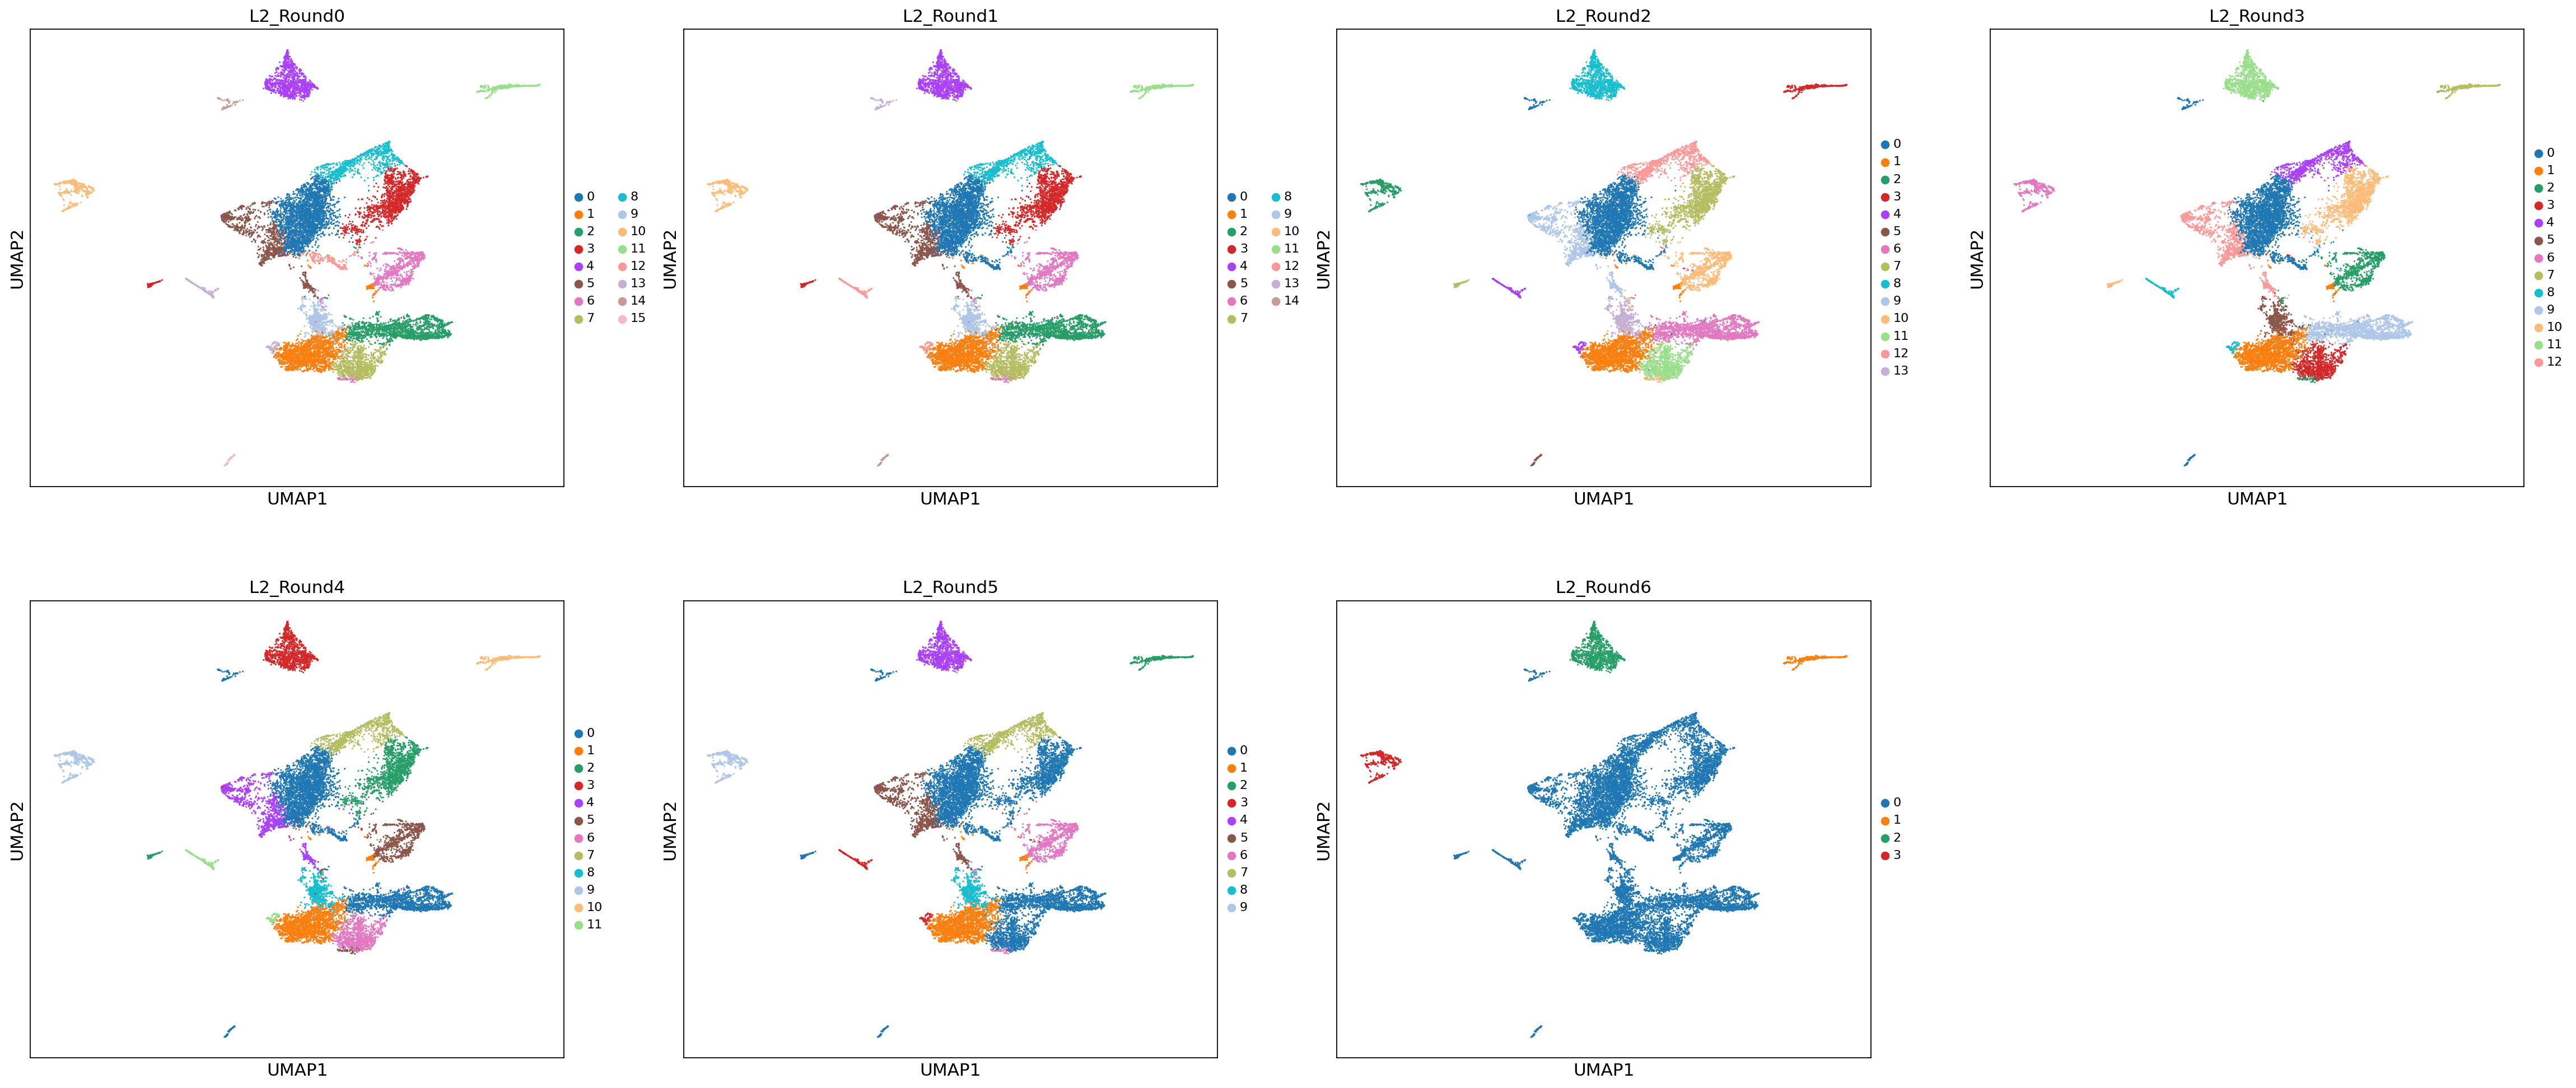

In [159]:
rcParams['figure.figsize'] = 8,7
sc.pl.umap(adata, color=['L2_Round0', 'L2_Round1', 'L2_Round2', 'L2_Round3', 'L2_Round4', 'L2_Round5', 'L2_Round6'], legend_fontsize = 10)

## PROJECT THE CHROMOTHRIPSIS SIGNATURE ON THE EMBEDDING

In [ ]:
adata = sc.read('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/adata_nuclei_Celltype.h5ad')  # the file that will store the analysis results)

In [77]:
# f="/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/MB_CT_vs_NCT_DESeq2.txt"
# f="/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/MB_CT_vs_NCT_DESeq2_TCC_GROUP.txt"
f="/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/MB_CT_vs_NCT_DESeq2_TCC_GROUP_wo_Immune.txt"
pos_df=pd.read_table(f, sep='\t')
pos_df=pos_df.loc[pos_df['log2FoldChange'] > 1,:]
pos_df=pos_df.loc[pos_df['padj'] <= 0.05,:]
neg_df=pd.read_table(f, sep='\t')
neg_df=neg_df.loc[neg_df['log2FoldChange'] < -1,:]
neg_df=neg_df.loc[neg_df['padj'] <= 0.05,:]

In [79]:
gene_list_pos=pos_df['gene_name']
intersect_gene_list_pos=adata.raw.var_names.isin(list(gene_list_pos))
gene_list_pos=adata.raw.var_names[intersect_gene_list_pos]

In [80]:
len(gene_list_pos)

172

In [81]:
gene_list_neg=neg_df['gene_name']
intersect_gene_list_neg=adata.raw.var_names.isin(list(gene_list_neg))
gene_list_neg=adata.raw.var_names[intersect_gene_list_neg]

In [82]:
len(gene_list_neg)

452

In [83]:
sc.tl.score_genes(adata, list(gene_list_pos), ctrl_size=len(gene_list_pos), gene_pool=None, n_bins=25, score_name='Upregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=True)
sc.tl.score_genes(adata, list(gene_list_neg), ctrl_size=len(gene_list_neg), gene_pool=None, n_bins=25, score_name='Downregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=True)

computing score 'Upregulated_Chromothripsis_Score'


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished: added
    'Upregulated_Chromothripsis_Score', score of gene set (adata.obs).
    2046 total control genes are used. (0:00:02)
computing score 'Downregulated_Chromothripsis_Score'
    finished: added
    'Downregulated_Chromothripsis_Score', score of gene set (adata.obs).
    4061 total control genes are used. (0:00:02)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


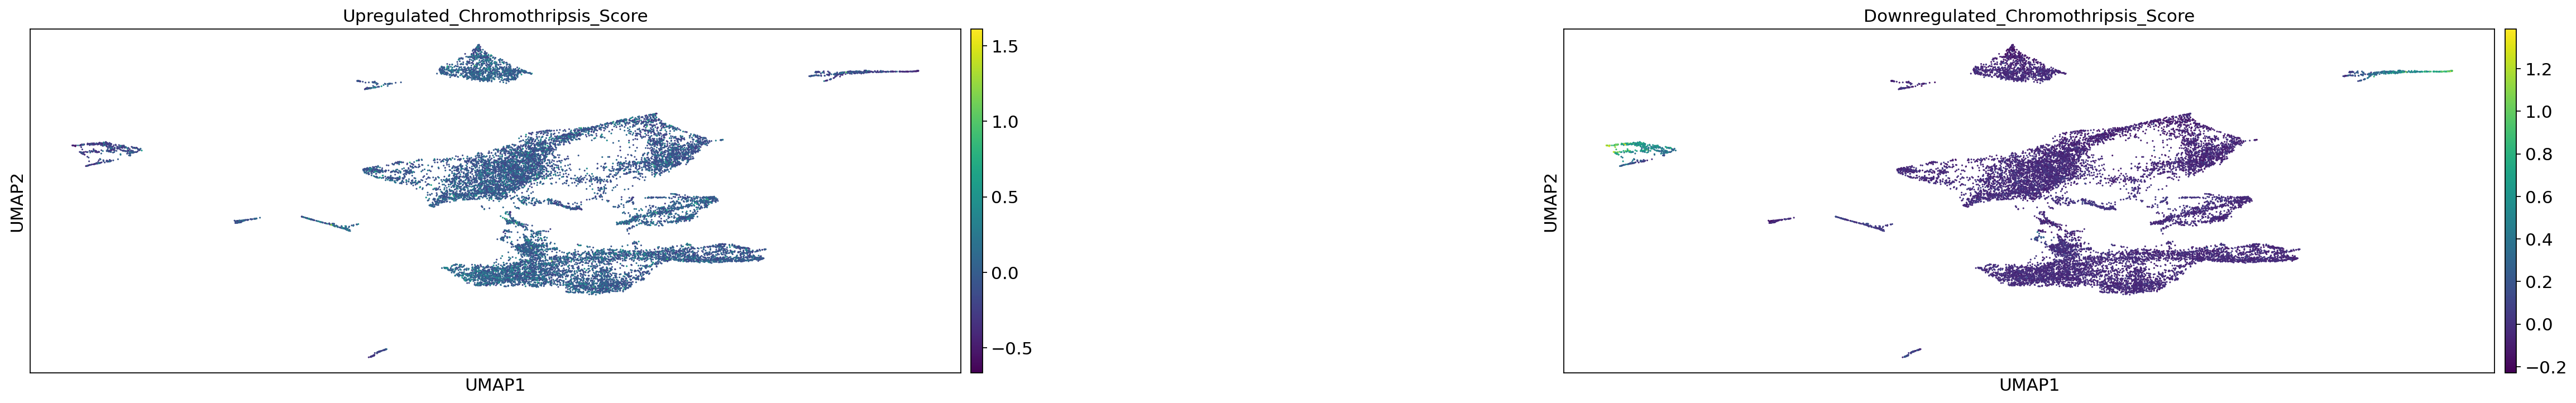

In [84]:
sc.pl.umap(adata, color=['Upregulated_Chromothripsis_Score', 'Downregulated_Chromothripsis_Score'], sort_order = False, save = '_Nuclei_chromothripsisScore_TCC_GROUP_wo_Immune.pdf', wspace = 0.5)

In [ ]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
# metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/Nuclei_projection_Riemondy_metadata.csv')
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/Nuclei_CT_scoring_bulk.csv')

In [ ]:
sc.pl.umap(adata, color=['VCAM1'], wspace = 0.5, save = '_MB243-Nuclei_VCAM1_marker_visualization.pdf', use_raw = True)